In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score,train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
gas = pd.read_csv('gas_turbines.csv')

In [3]:
gas.shape

(15039, 11)

In [4]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [5]:
gas.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,15039.0,17.764381,7.574323,0.522300,11.408000,18.1860,23.8625,34.9290
AP,15039.0,1013.199240,6.410760,985.850000,1008.900000,1012.8000,1016.9000,1034.2000
AH,15039.0,79.124174,13.793439,30.344000,69.750000,82.2660,90.0435,100.2000
AFDP,15039.0,4.200294,0.760197,2.087400,3.723900,4.1862,4.5509,7.6106
GTEP,15039.0,25.419061,4.173916,17.878000,23.294000,25.0820,27.1840,37.4020
TIT,15039.0,1083.798770,16.527806,1000.800000,1079.600000,1088.7000,1096.0000,1100.8000
TAT,15039.0,545.396183,7.866803,512.450000,542.170000,549.8900,550.0600,550.6100
TEY,15039.0,134.188464,15.829717,100.170000,127.985000,133.7800,140.8950,174.6100
CDP,15039.0,12.102353,1.103196,9.904400,11.622000,12.0250,12.5780,15.0810
CO,15039.0,1.972499,2.222206,0.000388,0.858055,1.3902,2.1604,44.1030


In [6]:
gas.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64

In [7]:
gas.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [8]:
gas.nunique()

AT      12086
AP        540
AH      12637
AFDP    11314
GTEP     8234
TIT       706
TAT      2340
TEY      4207
CDP      3611
CO      13096
NOX     11996
dtype: int64

In [9]:
gas[gas.duplicated()].shape

(0, 11)

In [10]:
gas.corr()['TEY'].sort_values(ascending = False)

TEY     1.000000
CDP     0.988473
GTEP    0.977042
TIT     0.891587
AFDP    0.717995
AP      0.146939
NOX    -0.102631
AH     -0.110272
AT     -0.207495
CO     -0.541751
TAT    -0.720356
Name: TEY, dtype: float64

In [11]:
numerical_features = gas.describe(include=["int64","float64"]).columns
numerical_features

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')

# Data Visualization

/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/4155797342.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gas[features], kde = False, label ='Skew = %.3f' %(skew), bins =30)


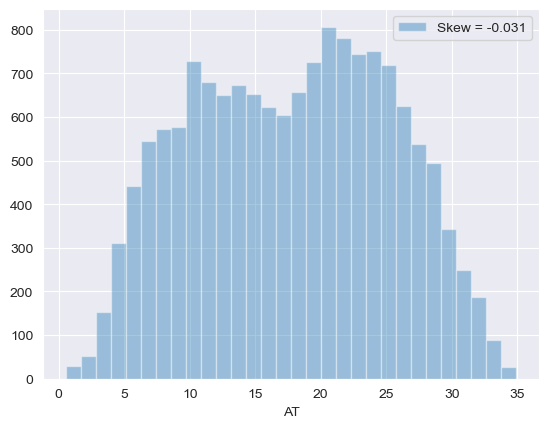

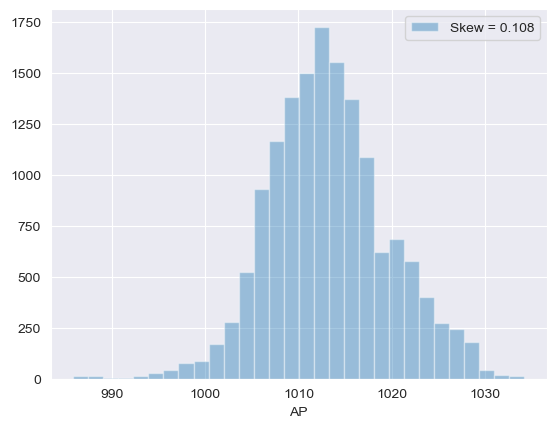

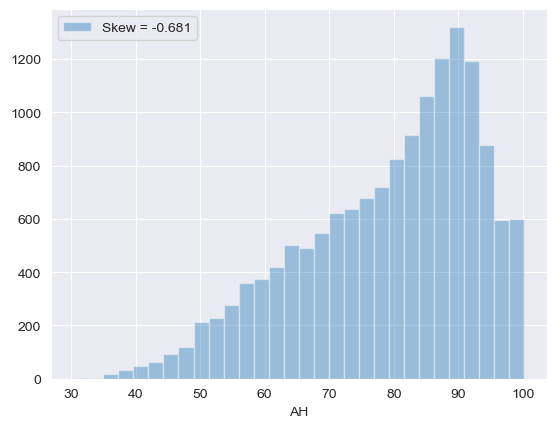

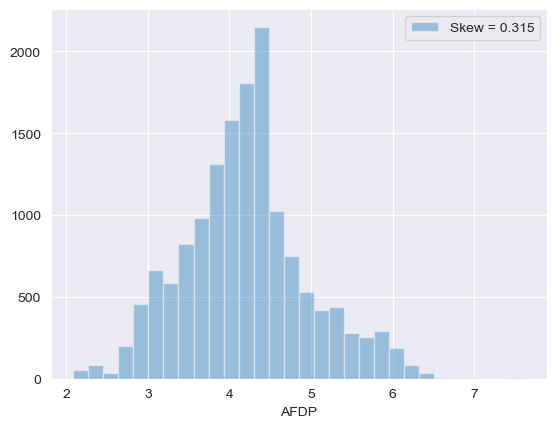

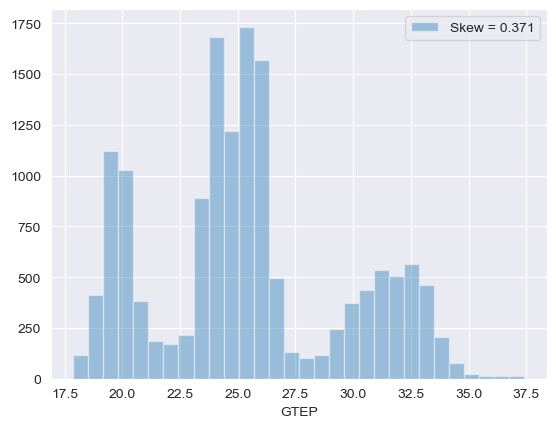

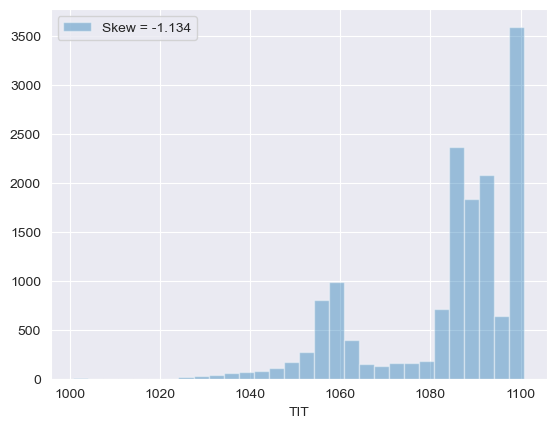

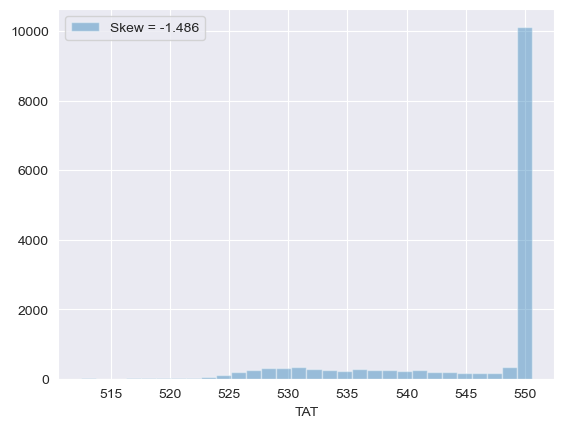

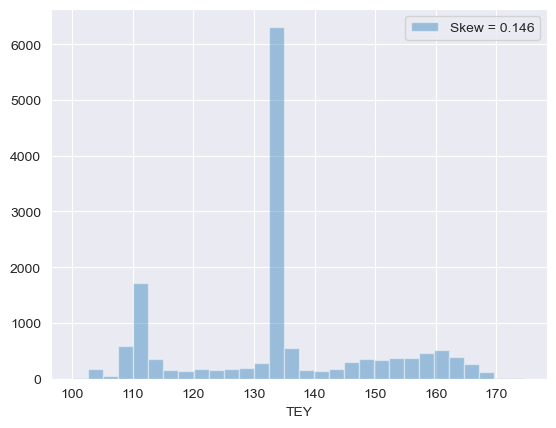

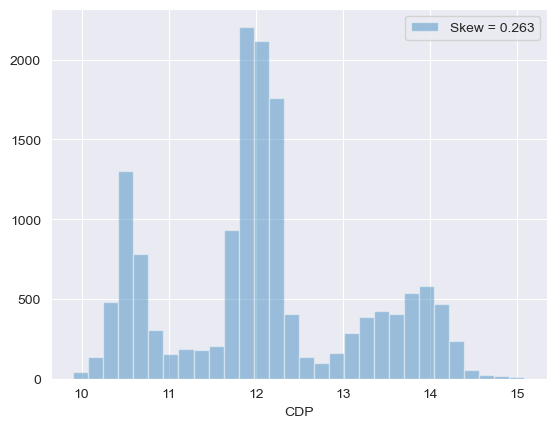

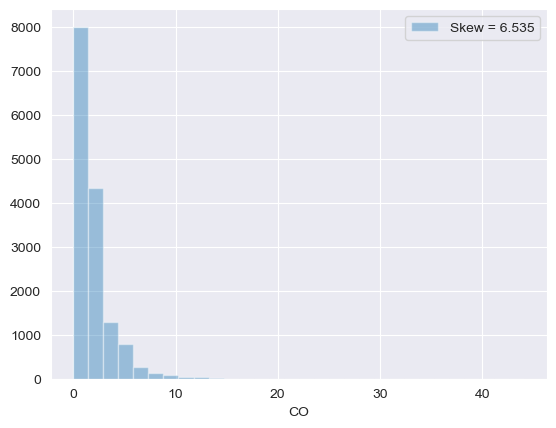

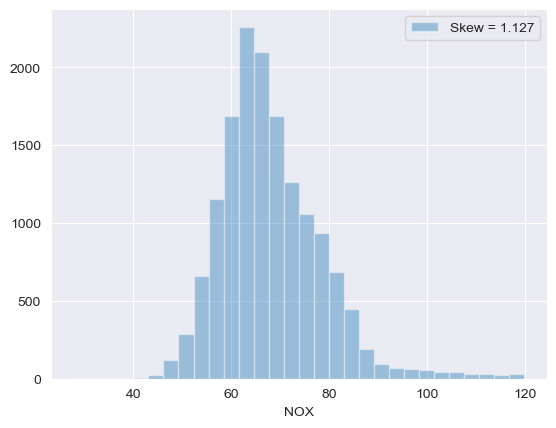

In [12]:
numerical_features = [feature for feature in gas.columns if gas[feature].dtypes != 'O']

for features in numerical_features:
    skew = gas[features].skew()
    sns.distplot(gas[features], kde = False, label ='Skew = %.3f' %(skew), bins =30)
    plt.legend(loc ='best')
    plt.show()

In [ ]:
'''
Some of the features are normally distributed.
The features AH, CO, TITy and TATa exhibit the highest skew coefficients.
Moreover, the distribution of Carbon Mono oxide (CO) and Turbine inlet temperature (TIT) and Turbine after temperature (TAT)
seem to contain many outliers.
'''

In [13]:
# Detect observations with more than one outlier

def outlier_hunt(gas):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in gas.columns.tolist():
        # 1st quartile (25%)
        Q1 = np.percentile(gas[col], 25)
        
        # 3rd quartile (75%)
        Q3 = np.percentile(gas[col],75)
        
        # Interquartile rrange (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = gas[(gas[col] < Q1 - outlier_step) | (gas[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )
    
    return multiple_outliers   

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(gas[numerical_features])))) 

The dataset contains 1543 observations with more than 2 outliers


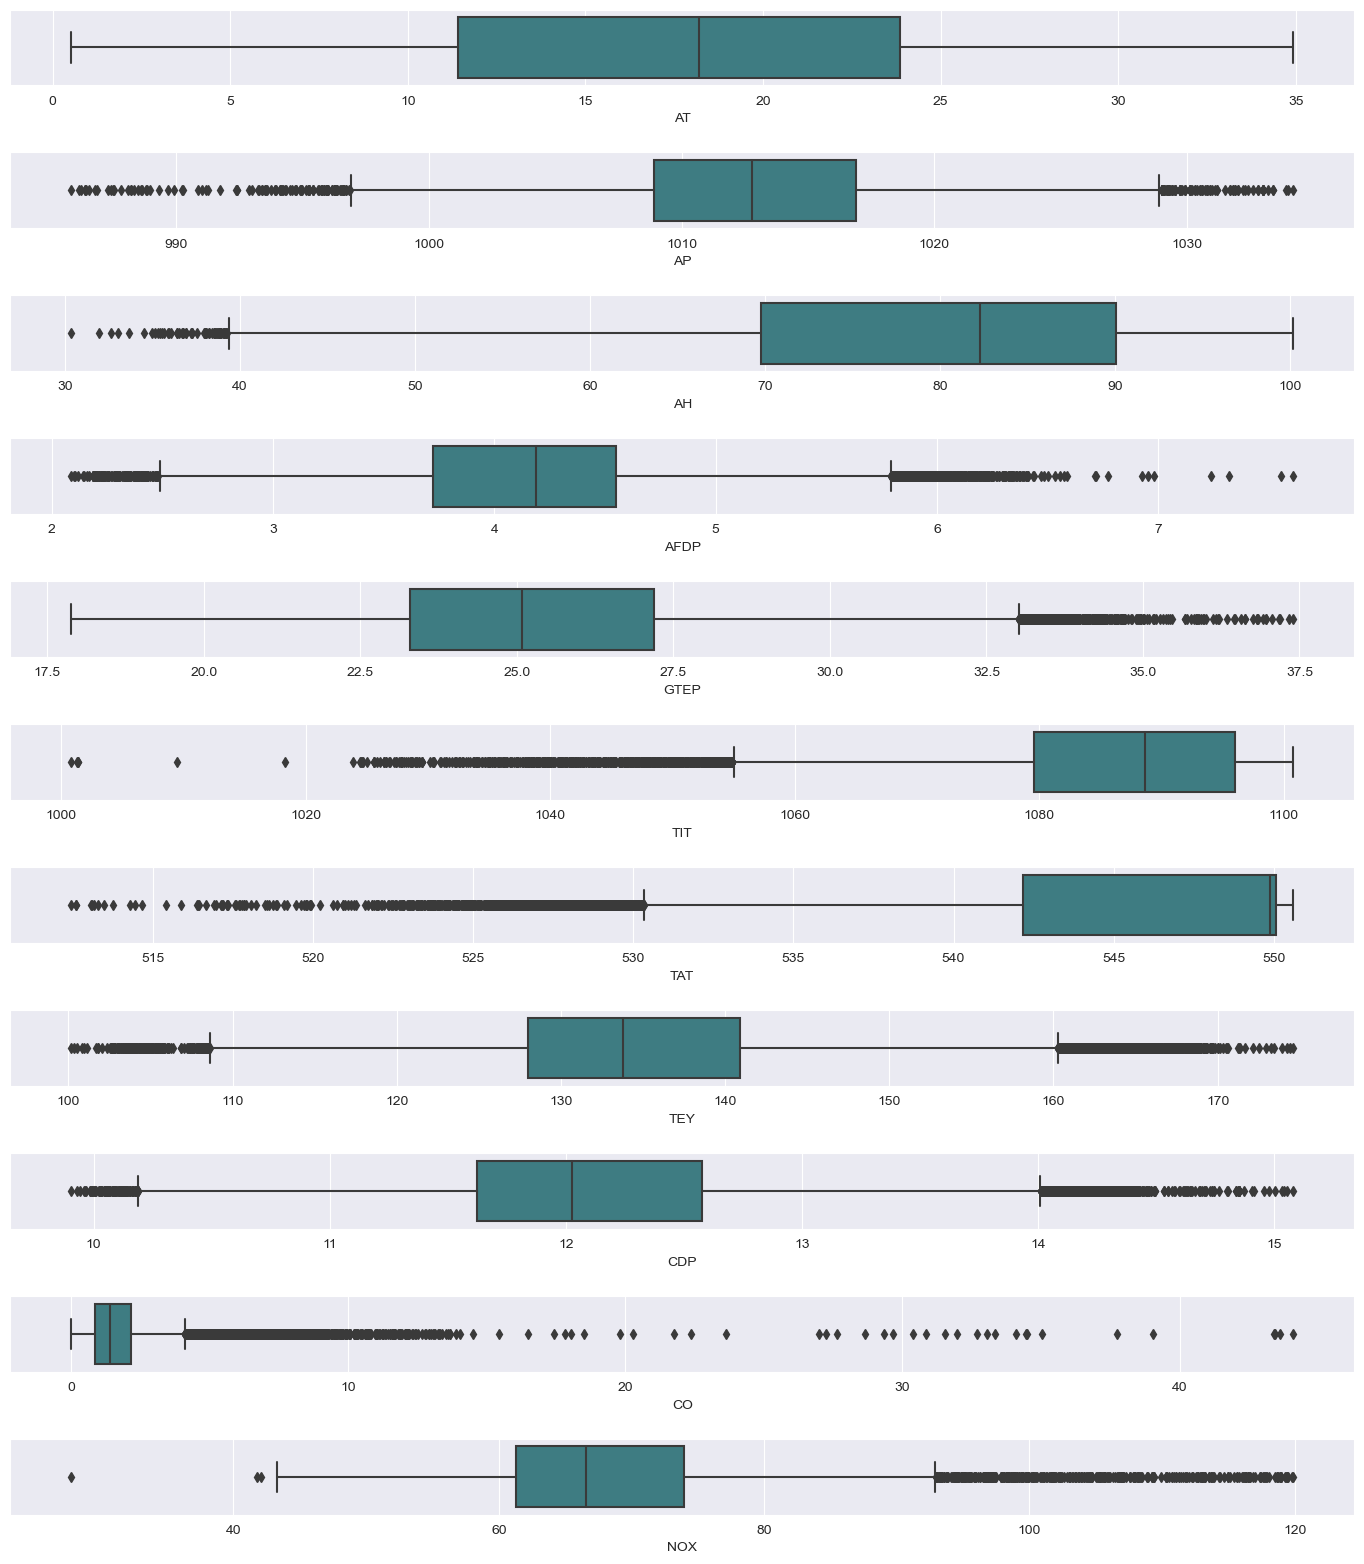

In [14]:
ot = gas.copy() 
fig, axes = plt.subplots(11,1,figsize = (14,16),sharex = False,sharey = False)
sns.boxplot(x ='AT',data = ot,palette ='crest',ax = axes[0])
sns.boxplot(x ='AP',data = ot,palette ='crest',ax = axes[1])
sns.boxplot(x ='AH',data = ot,palette ='crest',ax = axes[2])
sns.boxplot(x ='AFDP',data = ot,palette ='crest',ax = axes[3])
sns.boxplot(x ='GTEP',data = ot,palette ='crest',ax = axes[4])
sns.boxplot(x ='TIT',data = ot,palette ='crest',ax = axes[5])
sns.boxplot(x ='TAT',data = ot,palette ='crest',ax = axes[6])
sns.boxplot(x ='TEY',data = ot,palette ='crest',ax = axes[7])
sns.boxplot(x ='CDP',data = ot,palette ='crest',ax = axes[8])
sns.boxplot(x ='CO',data = ot,palette ='crest',ax = axes[9])
sns.boxplot(x ='NOX',data = ot,palette ='crest',ax = axes[10])
plt.tight_layout(pad=2.0)

<Axes: >

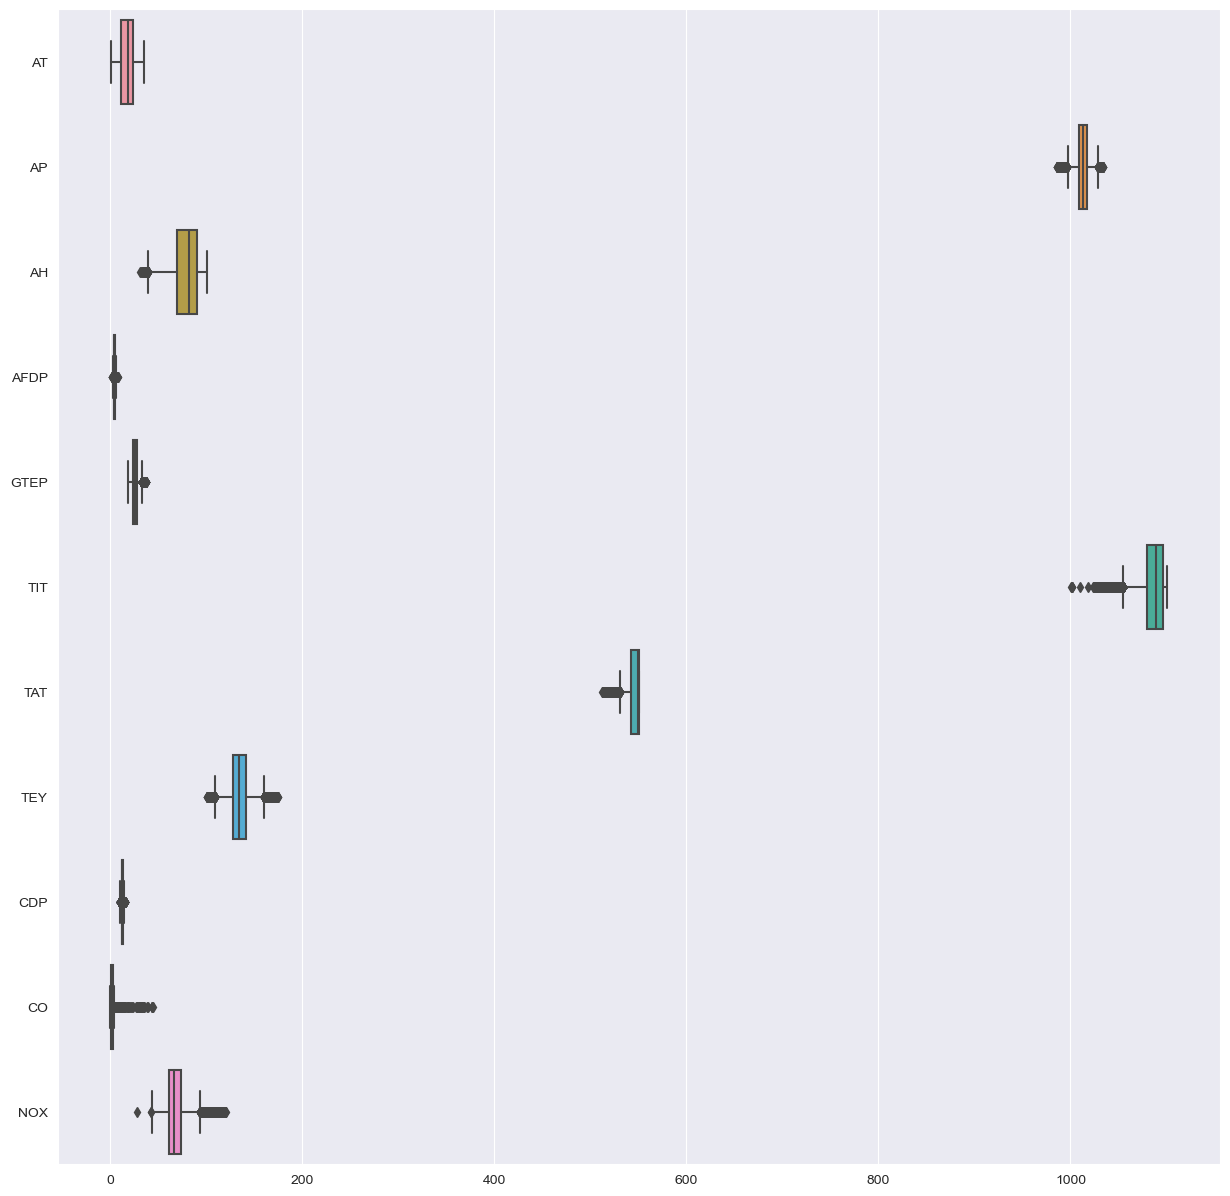

In [15]:
#outlier
plt.figure(figsize=(15,15))
sns.boxplot(data = gas[numerical_features], orient="h")

Text(0.5, 1.0, 'Histogram of the Target Column')

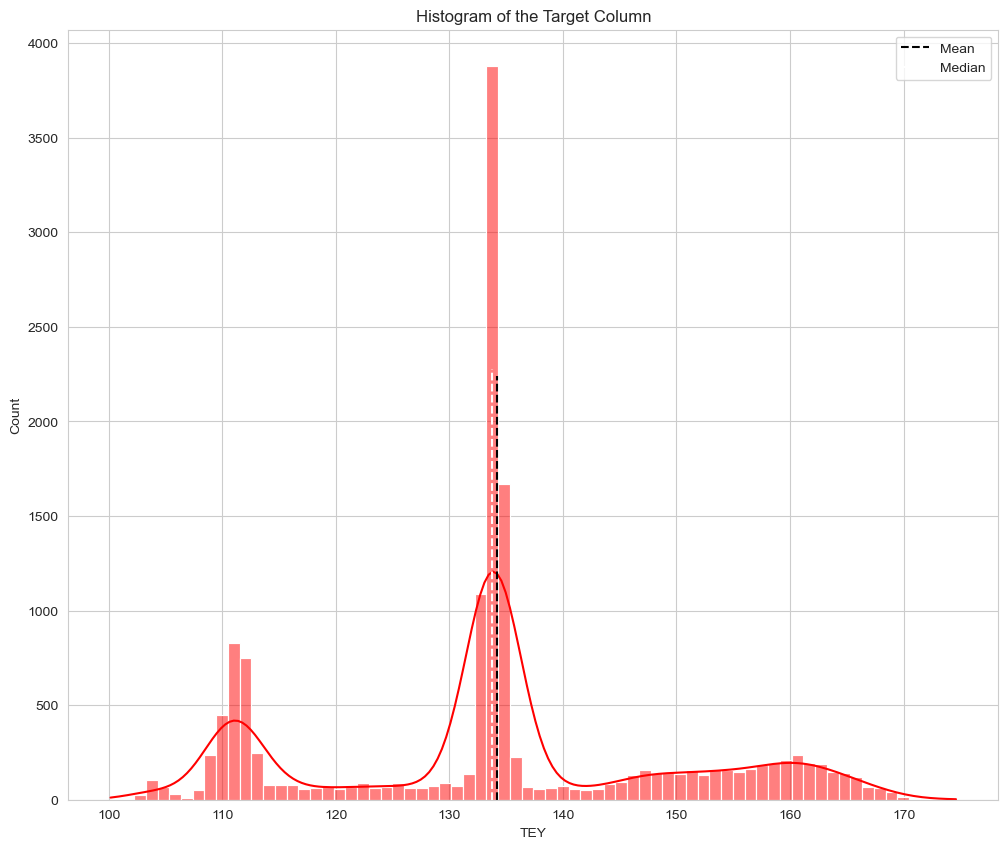

In [16]:
sns.set_style("whitegrid")
plt.figure(figsize = (12,10))
sns.histplot(data = gas,x ="TEY",color ="red",kde = True)
plt.axvline(x = gas["TEY"].mean(),ymax = 0.55,color = "black",linestyle ='--',label ="Mean")
plt.axvline(x = gas["TEY"].median(),ymax = 0.56,color = "white",linestyle ='--',label ="Median")
plt.legend()
plt.title("Histogram of the Target Column")

Text(0.5, 1.0, 'Cumulative of the Target Column')

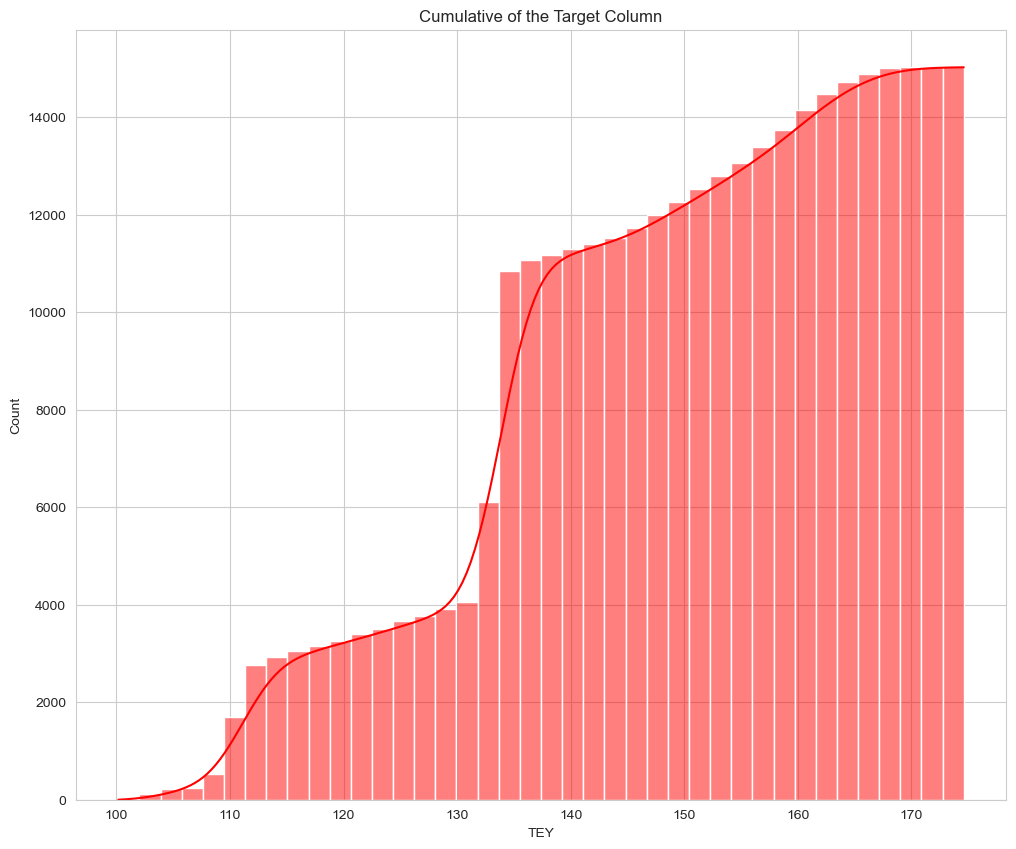

In [17]:
plt.figure(figsize = (12,10))
sns.histplot(gas["TEY"],kde = True,bins = 40,color = "red",cumulative = True)
plt.title("Cumulative of the Target Column")

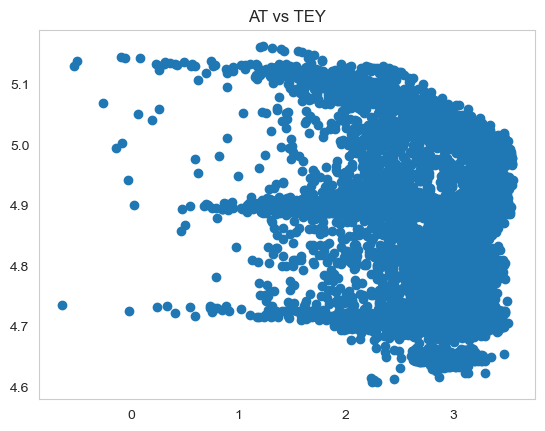

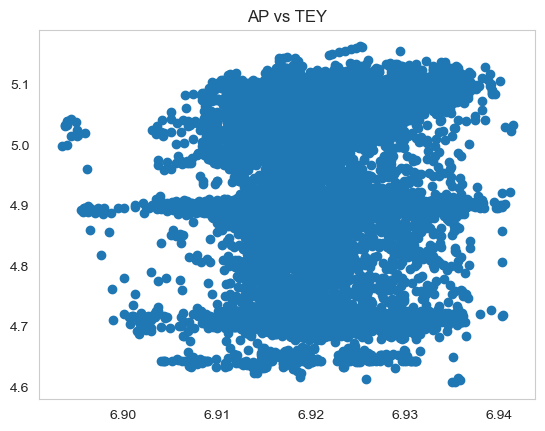

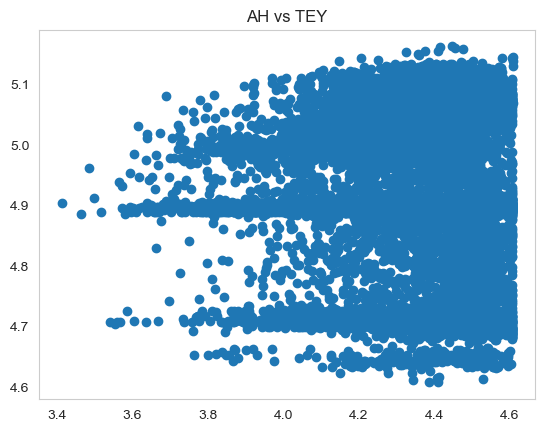

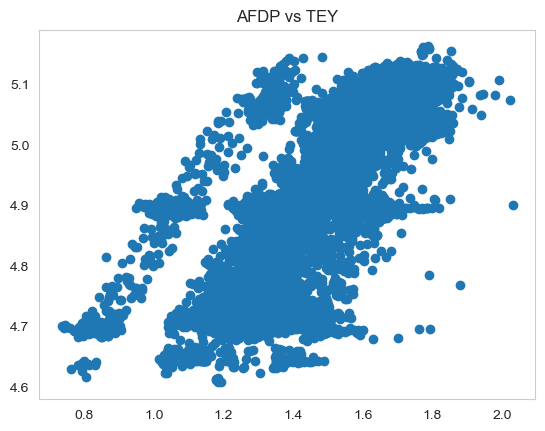

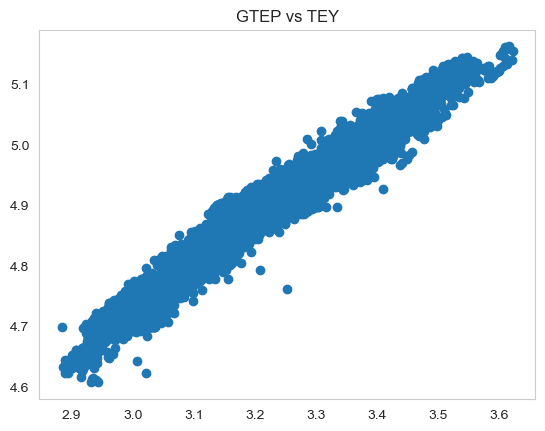

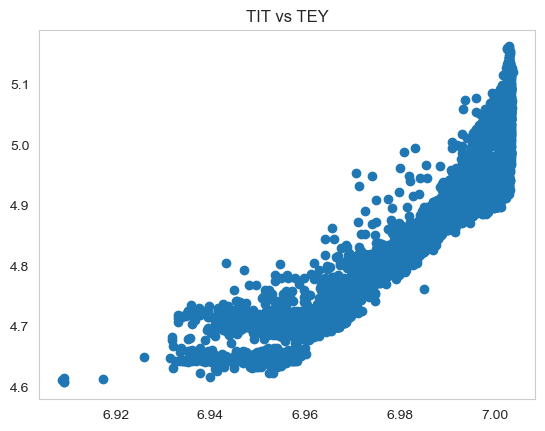

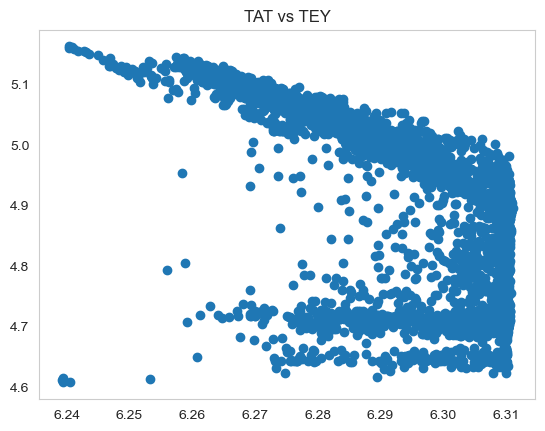

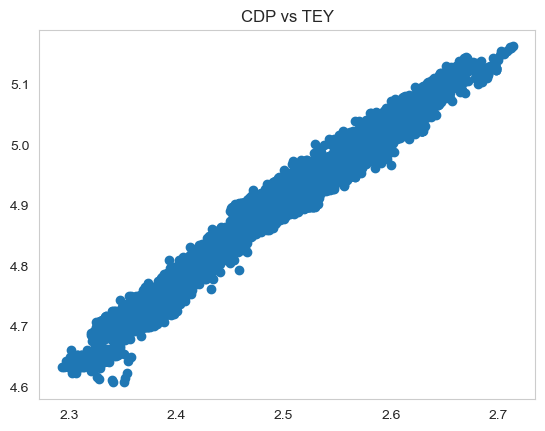

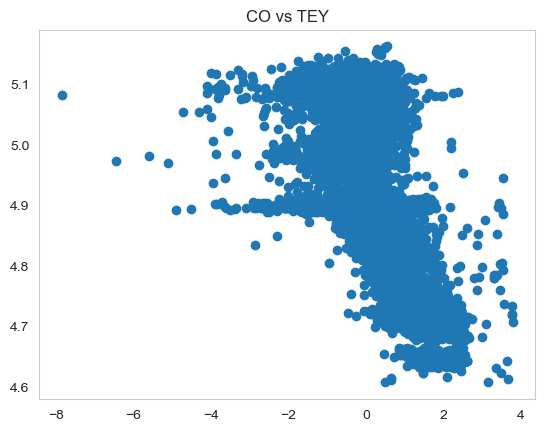

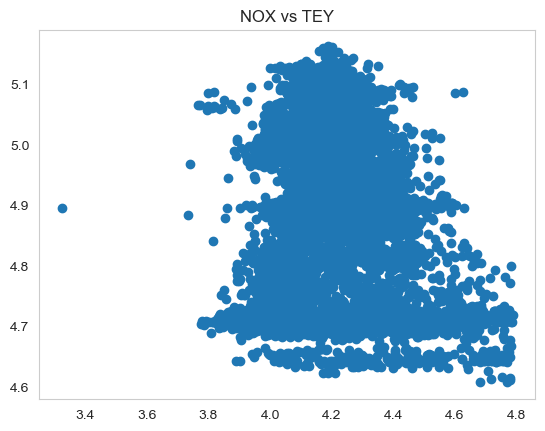

In [18]:
# drawing a pairplot to visually examine the correlation between the features.
for i in gas.columns:
    if i!="TEY": 
        plt.scatter(np.log(gas[i]), np.log(gas['TEY']))
        plt.title(i + ' vs TEY')
        plt.grid()
        plt.show()

<Axes: >

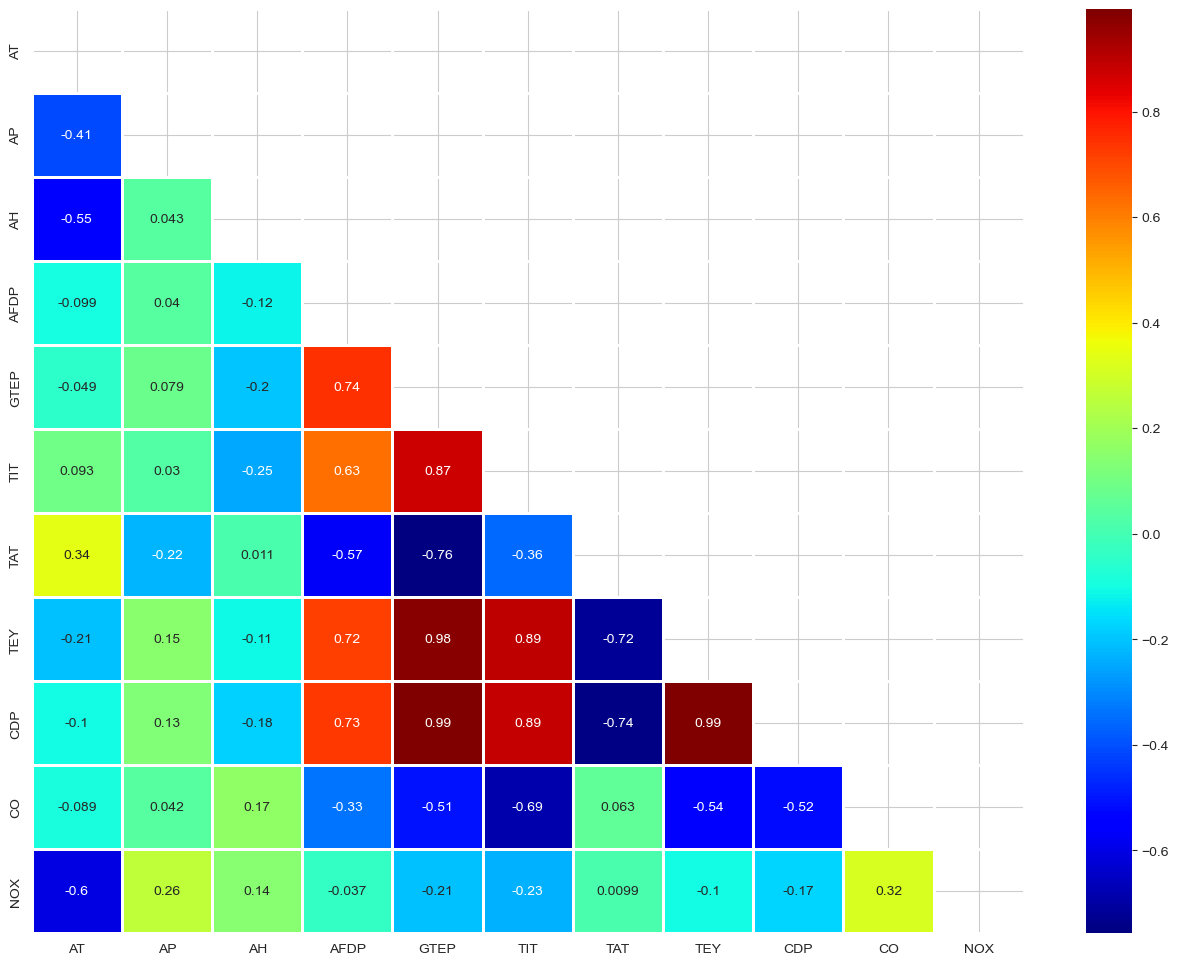

In [20]:
# Having a look at the correlation matrix

plt.figure(figsize=(16,12))
mask = np.zeros_like(gas.corr(), dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data = gas.corr(), cmap ="jet", annot = True,linewidths = 1, linecolor = 'white',mask = mask)

In [21]:
x = gas.drop('TEY', axis=1)
y = gas[["TEY"]]

Text(0.5, 1.0, 'Correlation with Turbine energy yield \n')

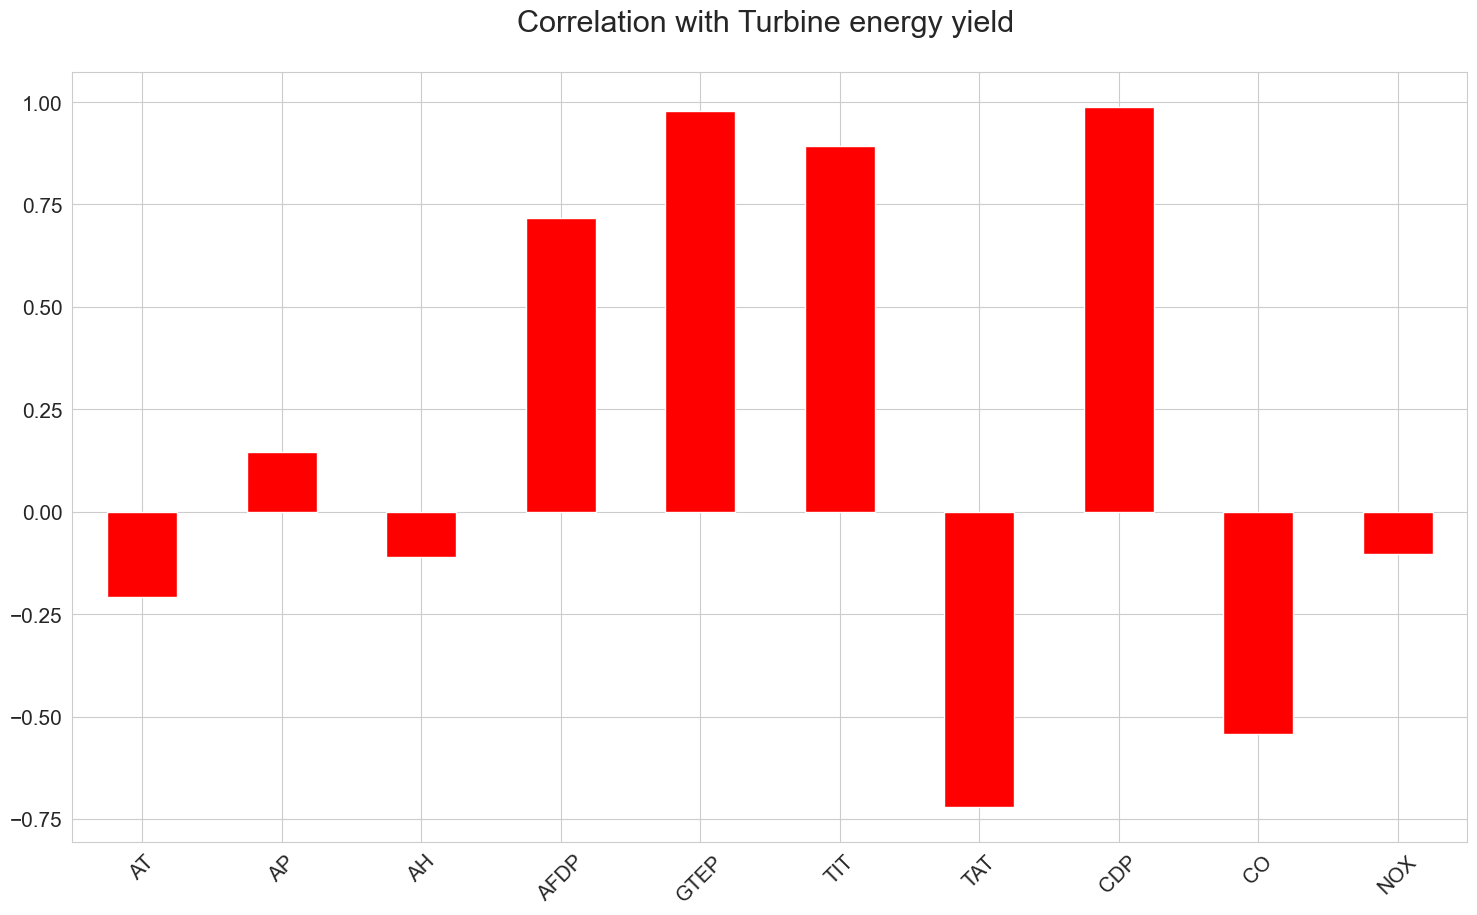

In [23]:
data2 = gas.copy()

correlations = data2.corrwith(gas.TEY)
correlations = correlations[correlations != 1]
positive_correlations = correlations[correlations > 0].sort_values(ascending = False)
negative_correlations =correlations[correlations < 0].sort_values(ascending = False)

correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = 'red',
        rot = 45, grid = True)
plt.title('Correlation with Turbine energy yield \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

In [29]:
#Feature importance
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
# feature extraction
test = sklearn.feature_selection.SelectKBest(k ='all')
fit = test.fit(x, y)

/Users/kishore/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [30]:
# summarize scores
scores = fit.scores_

features = fit.transform(x)

In [31]:
score_df = pd.DataFrame(list(zip(scores, x.columns)),
               columns = ['Score', 'Feature'])
score_df.sort_values(by ="Score", ascending = False, inplace = True)
score_df

,Score,Feature
7,209.370295,CDP
4,111.701841,GTEP
5,68.058586,TIT
6,50.815199,TAT
8,5.480562,CO
3,5.469623,AFDP
0,2.721856,AT
9,2.013558,NOX
2,1.575253,AH
1,1.551514,AP


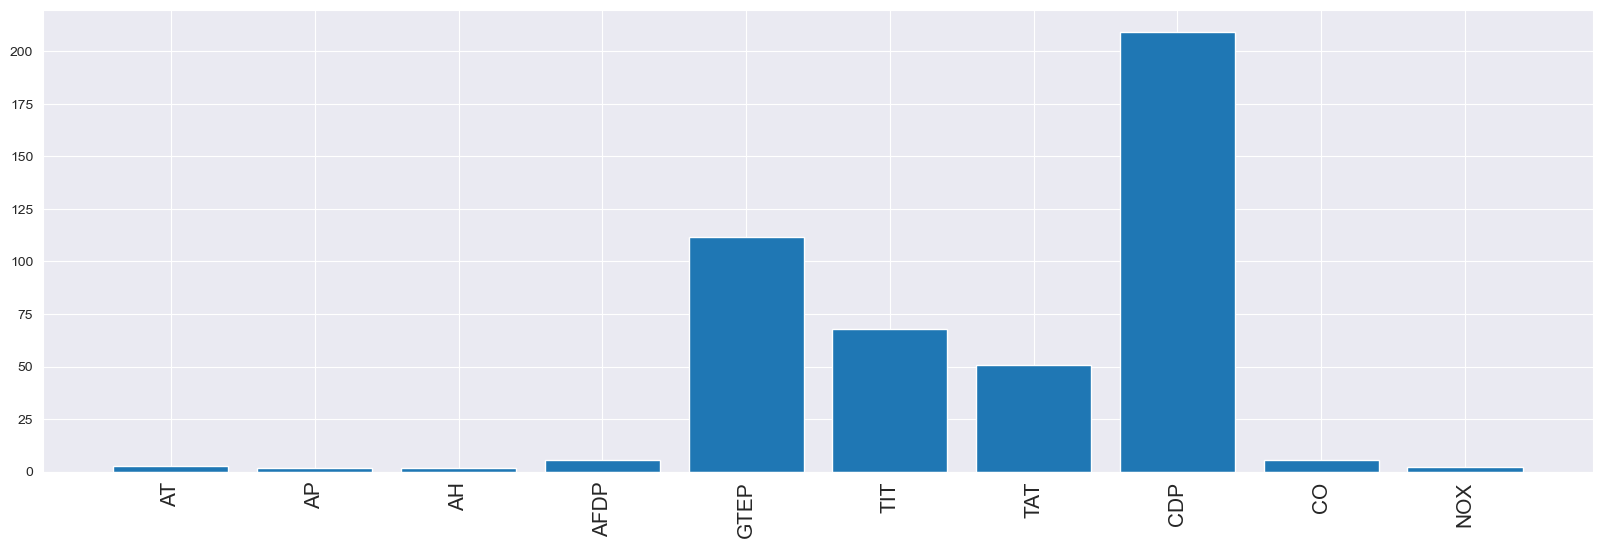

In [32]:
fig, axes = plt.subplots(figsize=(20, 6))
plt.bar([i for i in range(len(scores))],scores)
axes.set_xticks([0,1,2,3,4,5,6,7,8,9])
axes.set_xticklabels(x.columns.values)
plt.xticks(rotation = 90, size = 15)
plt.show()

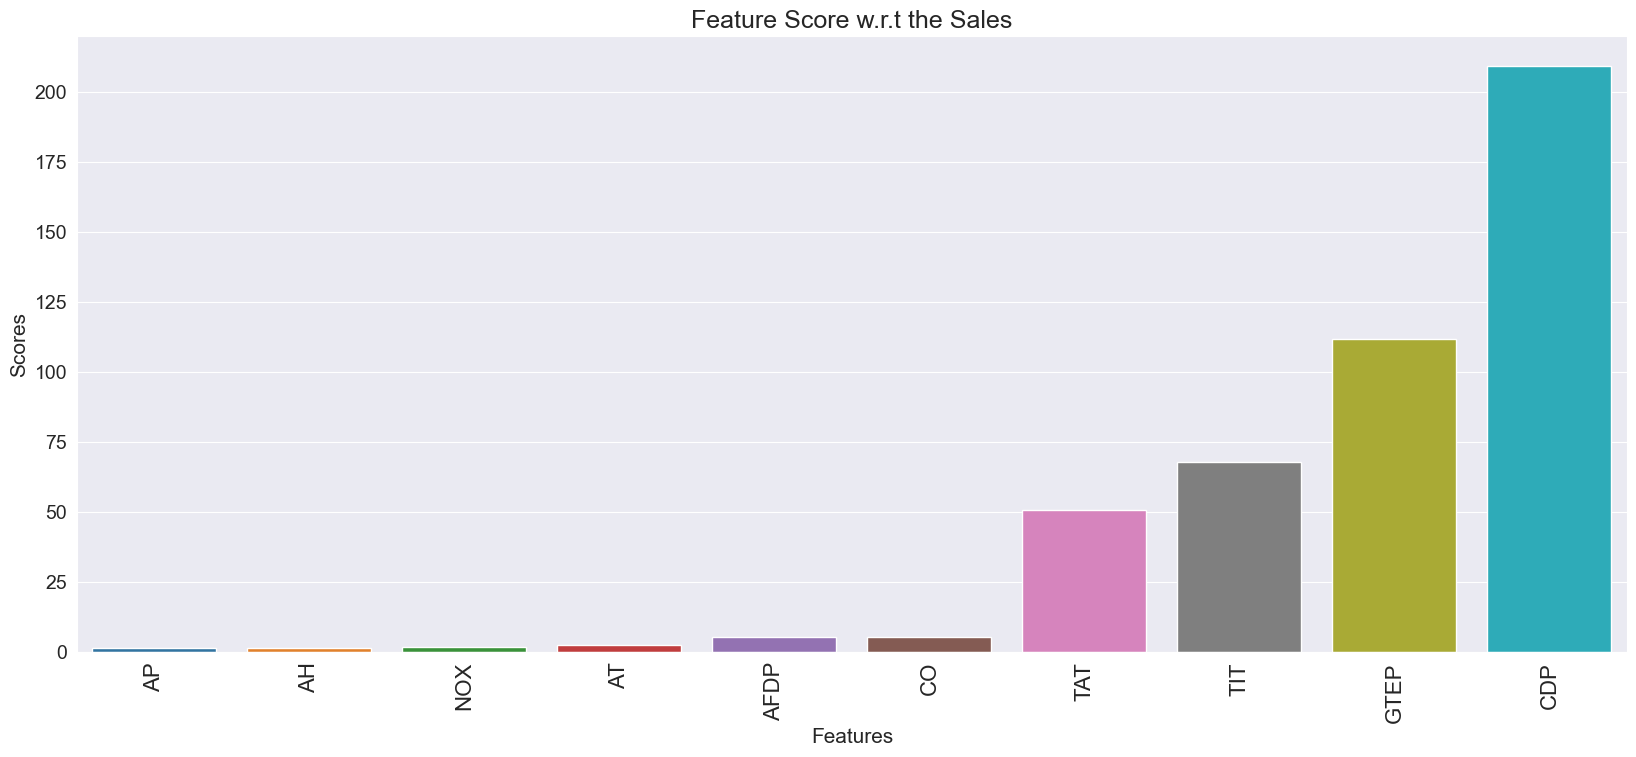

In [33]:
plt.figure(figsize=(20,8))
# make barplot and sort bars
sns.barplot(x='Feature',
            y="Score", 
            data=score_df, 
            order=score_df.sort_values('Score').Feature)
# set labels
plt.xlabel("Features", size=15)
plt.ylabel("Scores", size=15)
plt.yticks(rotation = 0, fontsize = 14)
plt.xticks(rotation = 90, fontsize = 16)
plt.title("Feature Score w.r.t the Sales", size=18)
plt.show()

In [34]:
score_df.sort_values('Score',ascending = False)

,Score,Feature
7,209.370295,CDP
4,111.701841,GTEP
5,68.058586,TIT
6,50.815199,TAT
8,5.480562,CO
3,5.469623,AFDP
0,2.721856,AT
9,2.013558,NOX
2,1.575253,AH
1,1.551514,AP


In [35]:
model_data = gas[['CDP', 'GTEP','TIT', 'TAT', 'AFDP', 'CO', 'AT',"TEY"]]
model_data.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


# Data preprocessing

In [36]:
continuous_feature=[feature for feature in model_data.columns if model_data[feature].dtype != 'O']
print('Continuous Feature Count {}'.format(len(continuous_feature)))

Continuous Feature Count 8


In [37]:
df_standard_scaled = model_data.copy()
features = df_standard_scaled[continuous_feature]

In [40]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
std = StandardScaler()

df_standard_scaled[continuous_feature] = std.fit_transform(features.values)
df_standard_scaled.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,-1.357331,-1.379101,-1.488376,0.585240,-0.921232,0.532012,-1.439778,-1.231172
1,-1.363676,-1.363528,-1.482325,0.585240,-0.921495,0.568733,-1.449601,-1.229909
2,-1.360957,-1.351309,-1.476275,0.568715,-0.944385,0.552938,-1.434721,-1.230541
3,-1.356424,-1.348194,-1.464173,0.583969,-0.946884,0.548933,-1.413702,-1.229909
4,-1.350985,-1.354663,-1.458123,0.582698,-0.924389,0.574179,-1.368693,-1.229909


In [41]:
x = df_standard_scaled.drop('TEY',axis=1)
y = df_standard_scaled[['TEY']]

In [43]:
# Splitting data into test data and train data
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score,train_test_split, RandomizedSearchCV

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=3)

# Hyperparameter Tuning

# Hyperparameter Tuning: Optimal Learning rate ,Number of Layers and Neurons

In [51]:
import tensorflow as tf
import tensorflow 

from tensorflow import keras
from keras.layers import Dense

tf.keras.optimizers.Adam

from tensorflow.keras import layers
from tensorflow import keras

from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.constraints import MaxNorm
from keras.layers import Wrapper
import scikeras
from scikeras.wrappers import KerasRegressor, KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [55]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units = hp.Int('units_' + str(i),
                                            min_value = 32,
                                            max_value = 100,
                                            step = 32),
                               activation = 'relu'))
    model.add(layers.Dense(1, activation = 'linear'))
    model.compile(
        optimizer = tf.keras.optimizers.legacy.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss ='mean_absolute_error',
        metrics = ['mean_absolute_error'])
    return model

In [56]:
from kerastuner.tuners import RandomSearch
from keras.models import Sequential

tuner = RandomSearch(build_model, objective ='val_mean_absolute_error',max_trials = 3,  executions_per_trial=  3, directory = 'project')

In [57]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 100, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [58]:
tuner.search(x_train, y_train, epochs = 100, validation_data = (x_test, y_test))

Oracle triggered exit


Trial 3 Complete [00h 02m 03s]
val_mean_absolute_error: 0.02479924075305462

Best val_mean_absolute_error So Far: 0.023937628294030826
Total elapsed time: 00h 04m 36s


In [59]:
tuner.results_summary()

Results summary
Results in project/untitled_project
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 0 summary
Hyperparameters:
num_layers: 3
units_0: 64
units_1: 32
learning_rate: 0.001
units_2: 32
Score: 0.023937628294030826

Trial 1 summary
Hyperparameters:
num_layers: 11
units_0: 96
units_1: 64
learning_rate: 0.001
units_2: 32
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
units_10: 32
Score: 0.024281365796923637

Trial 2 summary
Hyperparameters:
num_layers: 15
units_0: 32
units_1: 32
learning_rate: 0.0001
units_2: 64
units_3: 96
units_4: 32
units_5: 32
units_6: 64
units_7: 64
units_8: 32
units_9: 64
units_10: 96
units_11: 32
units_12: 32
units_13: 32
units_14: 32
Score: 0.02479924075305462


# Hyperparameter Tuning: Optimal Batch_size, Number of Epochs

In [63]:

def create_model():
    model1 = Sequential()
    model1.add(Dense(32,input_dim = 7,activation ='relu'))
    model1.add(Dense(64,activation ='relu'))
    model1.add(Dense(96,activation ="relu"))
    model1.add(Dense(32,activation ="relu"))
    model1.add(Dense(64,activation ="relu"))
    model1.add(Dense(32,activation ="relu"))
    model1.add(Dense(96,activation ="relu"))
    model1.add(Dense(96,activation ="relu"))
    model1.add(Dense(32,activation ="relu"))
    model1.add(Dense(64,activation ="relu"))
    model1.add(Dense(64,activation ="relu"))
    model1.add(Dense(units = 1,activation ="linear"))
    
    adam = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
    model1.compile(loss ='mean_absolute_error',optimizer = adam,metrics = ["mean_absolute_error"])
    return model1


In [64]:
model1 = KerasRegressor(model = create_model,verbose = 0)
batch_size = [10,20,40,50]
epochs = [10,50,100,200]
param_grid = dict(batch_size = batch_size,epochs = epochs)
grid = GridSearchCV(estimator = model1,param_grid = param_grid,cv = KFold(),verbose = 10)

In [65]:
grid_result = grid.fit(x_test,y_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START batch_size=10, epochs=10...................................
[CV 1/5; 1/16] END ....batch_size=10, epochs=10;, score=0.998 total time=   3.1s
[CV 2/5; 1/16] START batch_size=10, epochs=10...................................
[CV 2/5; 1/16] END ....batch_size=10, epochs=10;, score=0.996 total time=   3.1s
[CV 3/5; 1/16] START batch_size=10, epochs=10...................................
[CV 3/5; 1/16] END ....batch_size=10, epochs=10;, score=0.997 total time=   3.0s
[CV 4/5; 1/16] START batch_size=10, epochs=10...................................
[CV 4/5; 1/16] END ....batch_size=10, epochs=10;, score=0.998 total time=   3.0s
[CV 5/5; 1/16] START batch_size=10, epochs=10...................................
[CV 5/5; 1/16] END ....batch_size=10, epochs=10;, score=0.998 total time=   3.0s
[CV 1/5; 2/16] START batch_size=10, epochs=50...................................
[CV 1/5; 2/16] END ....batch_size=10, epochs=50;

[CV 1/5; 11/16] END ..batch_size=40, epochs=100;, score=0.998 total time=   8.2s
[CV 2/5; 11/16] START batch_size=40, epochs=100.................................
[CV 2/5; 11/16] END ..batch_size=40, epochs=100;, score=0.996 total time=   8.1s
[CV 3/5; 11/16] START batch_size=40, epochs=100.................................
[CV 3/5; 11/16] END ..batch_size=40, epochs=100;, score=0.998 total time=   8.2s
[CV 4/5; 11/16] START batch_size=40, epochs=100.................................
[CV 4/5; 11/16] END ..batch_size=40, epochs=100;, score=0.998 total time=   8.1s
[CV 5/5; 11/16] START batch_size=40, epochs=100.................................
[CV 5/5; 11/16] END ..batch_size=40, epochs=100;, score=0.998 total time=   8.2s
[CV 1/5; 12/16] START batch_size=40, epochs=200.................................
[CV 1/5; 12/16] END ..batch_size=40, epochs=200;, score=0.998 total time=  15.9s
[CV 2/5; 12/16] START batch_size=40, epochs=200.................................
[CV 2/5; 12/16] END ..batch_

In [66]:
print('Best {}, using {}'.format(grid_result.best_score_,grid_result.best_params_))
means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best 0.9982224913813973, using {'batch_size': 40, 'epochs': 200}
0.9973083468920008,0.000685706166175876 with {'batch_size': 10, 'epochs': 10}
0.9978867226258968,0.0005278724324131502 with {'batch_size': 10, 'epochs': 50}
0.9981394613955323,8.747449738260843e-05 with {'batch_size': 10, 'epochs': 100}
0.998207299346179,0.00027200252604125545 with {'batch_size': 10, 'epochs': 200}
0.9951806251435592,0.00168413538382585 with {'batch_size': 20, 'epochs': 10}
0.9980313784524592,0.00035037889672881857 with {'batch_size': 20, 'epochs': 50}
0.9979021523288345,0.0003578875418725136 with {'batch_size': 20, 'epochs': 100}
0.9982097312016721,0.0001654789033874899 with {'batch_size': 20, 'epochs': 200}
0.9965182256564533,0.000977528073525584 with {'batch_size': 40, 'epochs': 10}
0.9975499658451195,0.0009730662023667474 with {'batch_size': 40, 'epochs': 50}
0.9978489725607524,0.0007807005012841852 with {'batch_size': 40, 'epochs': 100}
0.9982224913813973,0.00015229356180628394 with {'batch_size': 40

# Hyperparameter Tuning: Optimal Droupout rate

In [67]:
def create_model(dropout_rate):
    model2 = Sequential()
    model2.add(Dense(32,input_dim = 7,activation ='relu'))
    model2.add(Dense(64,activation ='relu'))
    model2.add(Dense(96,activation ="relu"))
    model2.add(Dense(32,activation ="relu"))
    model2.add(Dense(64,activation ="relu"))
    model2.add(Dense(32,activation ="relu"))
    model2.add(Dense(96,activation ="relu"))
    model2.add(Dense(96,activation ="relu"))
    model2.add(Dense(32,activation ="relu"))
    model2.add(Dense(64,activation ="relu"))
    model2.add(Dense(64,activation ="relu"))
    model2.add(Dense(units = 1,activation ="linear"))
    
    adam = tf.keras.optimizers.legacy.Adam(lr = 0.001)
    model2.compile(loss = 'mean_absolute_error',optimizer = adam,metrics = ["mean_absolute_error"])
    return model2

In [70]:
model2 = KerasRegressor(model = create_model,batch_size = 40,epochs = 200, dropout_rate = 0.0)
dropout_rate = [0.0,0.1,0.2,0.3,0.4,0.5]
param_grid = dict(dropout_rate = dropout_rate)
grid2 = GridSearchCV(estimator = model2, param_grid = param_grid, cv = KFold(), verbose=10)

In [71]:
grid_result2 = grid2.fit(x_test,y_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START dropout_rate=0.0............................................
Epoch 1/200


/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 672us/step - loss: 0.2300 - mean_absolute_error: 0.2300
Epoch 2/200
91/91 [==============================] - 0s 895us/step - loss: 0.0480 - mean_absolute_error: 0.0480
Epoch 3/200
91/91 [==============================] - 0s 925us/step - loss: 0.0429 - mean_absolute_error: 0.0429
Epoch 4/200
91/91 [==============================] - 0s 906us/step - loss: 0.0404 - mean_absolute_error: 0.0404
Epoch 5/200
91/91 [==============================] - 0s 891us/step - loss: 0.0438 - mean_absolute_error: 0.0438
Epoch 6/200
91/91 [==============================] - 0s 909us/step - loss: 0.0406 - mean_absolute_error: 0.0406
Epoch 7/200
91/91 [==============================] - 0s 933us/step - loss: 0.0375 - mean_absolute_error: 0.0375
Epoch 8/200
91/91 [==============================] - 0s 915us/step - loss: 0.0382 - mean_absolute_error: 0.0382
Epoch 9/200
91/91 [==============================] - 0s 956us/step - loss: 0.0354 - mean_absolute_error: 0.0354
Epoc

91/91 [==============================] - 0s 921us/step - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 146/200
91/91 [==============================] - 0s 905us/step - loss: 0.0291 - mean_absolute_error: 0.0291
Epoch 147/200
91/91 [==============================] - 0s 905us/step - loss: 0.0288 - mean_absolute_error: 0.0288
Epoch 148/200
91/91 [==============================] - 0s 923us/step - loss: 0.0241 - mean_absolute_error: 0.0241
Epoch 149/200
91/91 [==============================] - 0s 902us/step - loss: 0.0238 - mean_absolute_error: 0.0238
Epoch 150/200
91/91 [==============================] - 0s 894us/step - loss: 0.0259 - mean_absolute_error: 0.0259
Epoch 151/200
91/91 [==============================] - 0s 919us/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 152/200
91/91 [==============================] - 0s 932us/step - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 153/200
91/91 [==============================] - 0s 900us/step - loss: 0.0266 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 663us/step - loss: 0.1960 - mean_absolute_error: 0.1960
Epoch 2/200
91/91 [==============================] - 0s 907us/step - loss: 0.0501 - mean_absolute_error: 0.0501
Epoch 3/200
91/91 [==============================] - 0s 920us/step - loss: 0.0489 - mean_absolute_error: 0.0489
Epoch 4/200
91/91 [==============================] - 0s 923us/step - loss: 0.0416 - mean_absolute_error: 0.0416
Epoch 5/200
91/91 [==============================] - 0s 907us/step - loss: 0.0400 - mean_absolute_error: 0.0400
Epoch 6/200
91/91 [==============================] - 0s 939us/step - loss: 0.0392 - mean_absolute_error: 0.0392
Epoch 7/200
91/91 [==============================] - 0s 907us/step - loss: 0.0378 - mean_absolute_error: 0.0378
Epoch 8/200
91/91 [==============================] - 0s 921us/step - loss: 0.0430 - mean_absolute_error: 0.0430
Epoch 9/200
91/91 [==============================] - 0s 910us/step - loss: 0.0367 - mean_absolute_error: 0.0367
Epoc

91/91 [==============================] - 0s 941us/step - loss: 0.0248 - mean_absolute_error: 0.0248
Epoch 146/200
91/91 [==============================] - 0s 923us/step - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 147/200
91/91 [==============================] - 0s 908us/step - loss: 0.0263 - mean_absolute_error: 0.0263
Epoch 148/200
91/91 [==============================] - 0s 910us/step - loss: 0.0248 - mean_absolute_error: 0.0248
Epoch 149/200
91/91 [==============================] - 0s 902us/step - loss: 0.0268 - mean_absolute_error: 0.0268
Epoch 150/200
91/91 [==============================] - 0s 896us/step - loss: 0.0284 - mean_absolute_error: 0.0284
Epoch 151/200
91/91 [==============================] - 0s 914us/step - loss: 0.0331 - mean_absolute_error: 0.0331
Epoch 152/200
91/91 [==============================] - 0s 919us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 153/200
91/91 [==============================] - 0s 901us/step - loss: 0.0287 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 647us/step - loss: 0.2182 - mean_absolute_error: 0.2182
Epoch 2/200
91/91 [==============================] - 0s 903us/step - loss: 0.0508 - mean_absolute_error: 0.0508
Epoch 3/200
91/91 [==============================] - 0s 925us/step - loss: 0.0540 - mean_absolute_error: 0.0540
Epoch 4/200
91/91 [==============================] - 0s 911us/step - loss: 0.0440 - mean_absolute_error: 0.0440
Epoch 5/200
91/91 [==============================] - 0s 907us/step - loss: 0.0449 - mean_absolute_error: 0.0449
Epoch 6/200
91/91 [==============================] - 0s 900us/step - loss: 0.0400 - mean_absolute_error: 0.0400
Epoch 7/200
91/91 [==============================] - 0s 902us/step - loss: 0.0373 - mean_absolute_error: 0.0373
Epoch 8/200
91/91 [==============================] - 0s 922us/step - loss: 0.0373 - mean_absolute_error: 0.0373
Epoch 9/200
91/91 [==============================] - 0s 910us/step - loss: 0.0380 - mean_absolute_error: 0.0380
Epoc

91/91 [==============================] - 0s 923us/step - loss: 0.0268 - mean_absolute_error: 0.0268
Epoch 146/200
91/91 [==============================] - 0s 901us/step - loss: 0.0244 - mean_absolute_error: 0.0244
Epoch 147/200
91/91 [==============================] - 0s 892us/step - loss: 0.0285 - mean_absolute_error: 0.0285
Epoch 148/200
91/91 [==============================] - 0s 899us/step - loss: 0.0269 - mean_absolute_error: 0.0269
Epoch 149/200
91/91 [==============================] - 0s 897us/step - loss: 0.0253 - mean_absolute_error: 0.0253
Epoch 150/200
91/91 [==============================] - 0s 907us/step - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 151/200
91/91 [==============================] - 0s 896us/step - loss: 0.0284 - mean_absolute_error: 0.0284
Epoch 152/200
91/91 [==============================] - 0s 906us/step - loss: 0.0257 - mean_absolute_error: 0.0257
Epoch 153/200
91/91 [==============================] - 0s 923us/step - loss: 0.0263 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 645us/step - loss: 0.2368 - mean_absolute_error: 0.2368
Epoch 2/200
91/91 [==============================] - 0s 916us/step - loss: 0.0506 - mean_absolute_error: 0.0506
Epoch 3/200
91/91 [==============================] - 0s 893us/step - loss: 0.0478 - mean_absolute_error: 0.0478
Epoch 4/200
91/91 [==============================] - 0s 891us/step - loss: 0.0457 - mean_absolute_error: 0.0457
Epoch 5/200
91/91 [==============================] - 0s 896us/step - loss: 0.0423 - mean_absolute_error: 0.0423
Epoch 6/200
91/91 [==============================] - 0s 919us/step - loss: 0.0400 - mean_absolute_error: 0.0400
Epoch 7/200
91/91 [==============================] - 0s 919us/step - loss: 0.0386 - mean_absolute_error: 0.0386
Epoch 8/200
91/91 [==============================] - 0s 917us/step - loss: 0.0398 - mean_absolute_error: 0.0398
Epoch 9/200
91/91 [==============================] - 0s 915us/step - loss: 0.0406 - mean_absolute_error: 0.0406
Epoc

91/91 [==============================] - 0s 934us/step - loss: 0.0270 - mean_absolute_error: 0.0270
Epoch 146/200
91/91 [==============================] - 0s 904us/step - loss: 0.0281 - mean_absolute_error: 0.0281
Epoch 147/200
91/91 [==============================] - 0s 898us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 148/200
91/91 [==============================] - 0s 909us/step - loss: 0.0260 - mean_absolute_error: 0.0260
Epoch 149/200
91/91 [==============================] - 0s 911us/step - loss: 0.0239 - mean_absolute_error: 0.0239
Epoch 150/200
91/91 [==============================] - 0s 911us/step - loss: 0.0290 - mean_absolute_error: 0.0290
Epoch 151/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0242 - mean_absolute_error: 0.0242
Epoch 152/200
91/91 [==============================] - 0s 903us/step - loss: 0.0257 - mean_absolute_error: 0.0257
Epoch 153/200
91/91 [==============================] - 0s 904us/step - loss: 0.0250 - mean_absolute_erro

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 663us/step - loss: 0.2156 - mean_absolute_error: 0.2156
Epoch 2/200
91/91 [==============================] - 0s 906us/step - loss: 0.0583 - mean_absolute_error: 0.0583
Epoch 3/200
91/91 [==============================] - 0s 893us/step - loss: 0.0518 - mean_absolute_error: 0.0518
Epoch 4/200
91/91 [==============================] - 0s 915us/step - loss: 0.0415 - mean_absolute_error: 0.0415
Epoch 5/200
91/91 [==============================] - 0s 910us/step - loss: 0.0371 - mean_absolute_error: 0.0371
Epoch 6/200
91/91 [==============================] - 0s 915us/step - loss: 0.0415 - mean_absolute_error: 0.0415
Epoch 7/200
91/91 [==============================] - 0s 901us/step - loss: 0.0427 - mean_absolute_error: 0.0427
Epoch 8/200
91/91 [==============================] - 0s 907us/step - loss: 0.0396 - mean_absolute_error: 0.0396
Epoch 9/200
91/91 [==============================] - 0s 902us/step - loss: 0.0410 - mean_absolute_error: 0.0410
Epoc

91/91 [==============================] - 0s 937us/step - loss: 0.0256 - mean_absolute_error: 0.0256
Epoch 146/200
91/91 [==============================] - 0s 930us/step - loss: 0.0272 - mean_absolute_error: 0.0272
Epoch 147/200
91/91 [==============================] - 0s 904us/step - loss: 0.0288 - mean_absolute_error: 0.0288
Epoch 148/200
91/91 [==============================] - 0s 901us/step - loss: 0.0268 - mean_absolute_error: 0.0268
Epoch 149/200
91/91 [==============================] - 0s 910us/step - loss: 0.0267 - mean_absolute_error: 0.0267
Epoch 150/200
91/91 [==============================] - 0s 912us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 151/200
91/91 [==============================] - 0s 921us/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 152/200
91/91 [==============================] - 0s 908us/step - loss: 0.0251 - mean_absolute_error: 0.0251
Epoch 153/200
91/91 [==============================] - 0s 892us/step - loss: 0.0273 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 653us/step - loss: 0.2194 - mean_absolute_error: 0.2194
Epoch 2/200
91/91 [==============================] - 0s 908us/step - loss: 0.0500 - mean_absolute_error: 0.0500
Epoch 3/200
91/91 [==============================] - 0s 899us/step - loss: 0.0449 - mean_absolute_error: 0.0449
Epoch 4/200
91/91 [==============================] - 0s 904us/step - loss: 0.0411 - mean_absolute_error: 0.0411
Epoch 5/200
91/91 [==============================] - 0s 1000us/step - loss: 0.0443 - mean_absolute_error: 0.0443
Epoch 6/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0389 - mean_absolute_error: 0.0389
Epoch 7/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0358 - mean_absolute_error: 0.0358
Epoch 8/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0386 - mean_absolute_error: 0.0386
Epoch 9/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0385 - mean_absolute_error: 0.0385
Epoch 10/20

91/91 [==============================] - 0s 910us/step - loss: 0.0262 - mean_absolute_error: 0.0262
Epoch 146/200
91/91 [==============================] - 0s 908us/step - loss: 0.0270 - mean_absolute_error: 0.0270
Epoch 147/200
91/91 [==============================] - 0s 914us/step - loss: 0.0261 - mean_absolute_error: 0.0261
Epoch 148/200
91/91 [==============================] - 0s 889us/step - loss: 0.0268 - mean_absolute_error: 0.0268
Epoch 149/200
91/91 [==============================] - 0s 904us/step - loss: 0.0257 - mean_absolute_error: 0.0257
Epoch 150/200
91/91 [==============================] - 0s 915us/step - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 151/200
91/91 [==============================] - 0s 892us/step - loss: 0.0276 - mean_absolute_error: 0.0276
Epoch 152/200
91/91 [==============================] - 0s 908us/step - loss: 0.0234 - mean_absolute_error: 0.0234
Epoch 153/200
91/91 [==============================] - 0s 890us/step - loss: 0.0238 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 654us/step - loss: 0.2013 - mean_absolute_error: 0.2013
Epoch 2/200
91/91 [==============================] - 0s 916us/step - loss: 0.0499 - mean_absolute_error: 0.0499
Epoch 3/200
91/91 [==============================] - 0s 913us/step - loss: 0.0467 - mean_absolute_error: 0.0467
Epoch 4/200
91/91 [==============================] - 0s 904us/step - loss: 0.0439 - mean_absolute_error: 0.0439
Epoch 5/200
91/91 [==============================] - 0s 916us/step - loss: 0.0461 - mean_absolute_error: 0.0461
Epoch 6/200
91/91 [==============================] - 0s 916us/step - loss: 0.0427 - mean_absolute_error: 0.0427
Epoch 7/200
91/91 [==============================] - 0s 907us/step - loss: 0.0388 - mean_absolute_error: 0.0388
Epoch 8/200
91/91 [==============================] - 0s 915us/step - loss: 0.0411 - mean_absolute_error: 0.0411
Epoch 9/200
91/91 [==============================] - 0s 919us/step - loss: 0.0401 - mean_absolute_error: 0.0401
Epoc

91/91 [==============================] - 0s 938us/step - loss: 0.0244 - mean_absolute_error: 0.0244
Epoch 146/200
91/91 [==============================] - 0s 918us/step - loss: 0.0238 - mean_absolute_error: 0.0238
Epoch 147/200
91/91 [==============================] - 0s 913us/step - loss: 0.0258 - mean_absolute_error: 0.0258
Epoch 148/200
91/91 [==============================] - 0s 903us/step - loss: 0.0249 - mean_absolute_error: 0.0249
Epoch 149/200
91/91 [==============================] - 0s 914us/step - loss: 0.0237 - mean_absolute_error: 0.0237
Epoch 150/200
91/91 [==============================] - 0s 908us/step - loss: 0.0268 - mean_absolute_error: 0.0268
Epoch 151/200
91/91 [==============================] - 0s 928us/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 152/200
91/91 [==============================] - 0s 915us/step - loss: 0.0277 - mean_absolute_error: 0.0277
Epoch 153/200
91/91 [==============================] - 0s 965us/step - loss: 0.0270 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 645us/step - loss: 0.2173 - mean_absolute_error: 0.2173
Epoch 2/200
91/91 [==============================] - 0s 920us/step - loss: 0.0633 - mean_absolute_error: 0.0633
Epoch 3/200
91/91 [==============================] - 0s 916us/step - loss: 0.0478 - mean_absolute_error: 0.0478
Epoch 4/200
91/91 [==============================] - 0s 922us/step - loss: 0.0467 - mean_absolute_error: 0.0467
Epoch 5/200
91/91 [==============================] - 0s 908us/step - loss: 0.0473 - mean_absolute_error: 0.0473
Epoch 6/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0446 - mean_absolute_error: 0.0446
Epoch 7/200
91/91 [==============================] - 0s 911us/step - loss: 0.0384 - mean_absolute_error: 0.0384
Epoch 8/200
91/91 [==============================] - 0s 922us/step - loss: 0.0395 - mean_absolute_error: 0.0395
Epoch 9/200
91/91 [==============================] - 0s 921us/step - loss: 0.0404 - mean_absolute_error: 0.0404
Epoch 

91/91 [==============================] - 0s 957us/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 146/200
91/91 [==============================] - 0s 908us/step - loss: 0.0238 - mean_absolute_error: 0.0238
Epoch 147/200
91/91 [==============================] - 0s 921us/step - loss: 0.0251 - mean_absolute_error: 0.0251
Epoch 148/200
91/91 [==============================] - 0s 904us/step - loss: 0.0240 - mean_absolute_error: 0.0240
Epoch 149/200
91/91 [==============================] - 0s 902us/step - loss: 0.0261 - mean_absolute_error: 0.0261
Epoch 150/200
91/91 [==============================] - 0s 909us/step - loss: 0.0262 - mean_absolute_error: 0.0262
Epoch 151/200
91/91 [==============================] - 0s 907us/step - loss: 0.0241 - mean_absolute_error: 0.0241
Epoch 152/200
91/91 [==============================] - 0s 887us/step - loss: 0.0262 - mean_absolute_error: 0.0262
Epoch 153/200
91/91 [==============================] - 0s 900us/step - loss: 0.0265 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 659us/step - loss: 0.2006 - mean_absolute_error: 0.2006
Epoch 2/200
91/91 [==============================] - 0s 925us/step - loss: 0.0480 - mean_absolute_error: 0.0480
Epoch 3/200
91/91 [==============================] - 0s 910us/step - loss: 0.0465 - mean_absolute_error: 0.0465
Epoch 4/200
91/91 [==============================] - 0s 911us/step - loss: 0.0407 - mean_absolute_error: 0.0407
Epoch 5/200
91/91 [==============================] - 0s 918us/step - loss: 0.0407 - mean_absolute_error: 0.0407
Epoch 6/200
91/91 [==============================] - 0s 908us/step - loss: 0.0415 - mean_absolute_error: 0.0415
Epoch 7/200
91/91 [==============================] - 0s 918us/step - loss: 0.0368 - mean_absolute_error: 0.0368
Epoch 8/200
91/91 [==============================] - 0s 904us/step - loss: 0.0413 - mean_absolute_error: 0.0413
Epoch 9/200
91/91 [==============================] - 0s 908us/step - loss: 0.0413 - mean_absolute_error: 0.0413
Epoc

91/91 [==============================] - 0s 902us/step - loss: 0.0269 - mean_absolute_error: 0.0269
Epoch 146/200
91/91 [==============================] - 0s 914us/step - loss: 0.0276 - mean_absolute_error: 0.0276
Epoch 147/200
91/91 [==============================] - 0s 909us/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 148/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0244 - mean_absolute_error: 0.0244
Epoch 149/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0267 - mean_absolute_error: 0.0267
Epoch 150/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0305 - mean_absolute_error: 0.0305
Epoch 151/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0257 - mean_absolute_error: 0.0257
Epoch 152/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 153/200
91/91 [==============================] - 0s 910us/step - loss: 0.0265 - mean_absolute_error: 0.026

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 653us/step - loss: 0.2443 - mean_absolute_error: 0.2443
Epoch 2/200
91/91 [==============================] - 0s 902us/step - loss: 0.0514 - mean_absolute_error: 0.0514
Epoch 3/200
91/91 [==============================] - 0s 914us/step - loss: 0.0485 - mean_absolute_error: 0.0485
Epoch 4/200
91/91 [==============================] - 0s 903us/step - loss: 0.0443 - mean_absolute_error: 0.0443
Epoch 5/200
91/91 [==============================] - 0s 911us/step - loss: 0.0412 - mean_absolute_error: 0.0412
Epoch 6/200
91/91 [==============================] - 0s 908us/step - loss: 0.0398 - mean_absolute_error: 0.0398
Epoch 7/200
91/91 [==============================] - 0s 905us/step - loss: 0.0460 - mean_absolute_error: 0.0460
Epoch 8/200
91/91 [==============================] - 0s 912us/step - loss: 0.0397 - mean_absolute_error: 0.0397
Epoch 9/200
91/91 [==============================] - 0s 901us/step - loss: 0.0369 - mean_absolute_error: 0.0369
Epoc

91/91 [==============================] - 0s 930us/step - loss: 0.0264 - mean_absolute_error: 0.0264
Epoch 146/200
91/91 [==============================] - 0s 907us/step - loss: 0.0263 - mean_absolute_error: 0.0263
Epoch 147/200
91/91 [==============================] - 0s 918us/step - loss: 0.0287 - mean_absolute_error: 0.0287
Epoch 148/200
91/91 [==============================] - 0s 911us/step - loss: 0.0307 - mean_absolute_error: 0.0307
Epoch 149/200
91/91 [==============================] - 0s 893us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 150/200
91/91 [==============================] - 0s 907us/step - loss: 0.0290 - mean_absolute_error: 0.0290
Epoch 151/200
91/91 [==============================] - 0s 905us/step - loss: 0.0273 - mean_absolute_error: 0.0273
Epoch 152/200
91/91 [==============================] - 0s 907us/step - loss: 0.0263 - mean_absolute_error: 0.0263
Epoch 153/200
91/91 [==============================] - 0s 921us/step - loss: 0.0257 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 657us/step - loss: 0.1872 - mean_absolute_error: 0.1872
Epoch 2/200
91/91 [==============================] - 0s 913us/step - loss: 0.0541 - mean_absolute_error: 0.0541
Epoch 3/200
91/91 [==============================] - 0s 899us/step - loss: 0.0436 - mean_absolute_error: 0.0436
Epoch 4/200
91/91 [==============================] - 0s 906us/step - loss: 0.0492 - mean_absolute_error: 0.0492
Epoch 5/200
91/91 [==============================] - 0s 907us/step - loss: 0.0392 - mean_absolute_error: 0.0392
Epoch 6/200
91/91 [==============================] - 0s 906us/step - loss: 0.0391 - mean_absolute_error: 0.0391
Epoch 7/200
91/91 [==============================] - 0s 915us/step - loss: 0.0409 - mean_absolute_error: 0.0409
Epoch 8/200
91/91 [==============================] - 0s 901us/step - loss: 0.0343 - mean_absolute_error: 0.0343
Epoch 9/200
91/91 [==============================] - 0s 911us/step - loss: 0.0398 - mean_absolute_error: 0.0398
Epoc

91/91 [==============================] - 0s 915us/step - loss: 0.0270 - mean_absolute_error: 0.0270
Epoch 146/200
91/91 [==============================] - 0s 908us/step - loss: 0.0241 - mean_absolute_error: 0.0241
Epoch 147/200
91/91 [==============================] - 0s 909us/step - loss: 0.0275 - mean_absolute_error: 0.0275
Epoch 148/200
91/91 [==============================] - 0s 907us/step - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 149/200
91/91 [==============================] - 0s 897us/step - loss: 0.0247 - mean_absolute_error: 0.0247
Epoch 150/200
91/91 [==============================] - 0s 905us/step - loss: 0.0290 - mean_absolute_error: 0.0290
Epoch 151/200
91/91 [==============================] - 0s 901us/step - loss: 0.0259 - mean_absolute_error: 0.0259
Epoch 152/200
91/91 [==============================] - 0s 898us/step - loss: 0.0251 - mean_absolute_error: 0.0251
Epoch 153/200
91/91 [==============================] - 0s 920us/step - loss: 0.0257 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 658us/step - loss: 0.2425 - mean_absolute_error: 0.2425
Epoch 2/200
91/91 [==============================] - 0s 902us/step - loss: 0.0571 - mean_absolute_error: 0.0571
Epoch 3/200
91/91 [==============================] - 0s 916us/step - loss: 0.0505 - mean_absolute_error: 0.0505
Epoch 4/200
91/91 [==============================] - 0s 922us/step - loss: 0.0493 - mean_absolute_error: 0.0493
Epoch 5/200
91/91 [==============================] - 0s 905us/step - loss: 0.0406 - mean_absolute_error: 0.0406
Epoch 6/200
91/91 [==============================] - 0s 916us/step - loss: 0.0527 - mean_absolute_error: 0.0527
Epoch 7/200
91/91 [==============================] - 0s 911us/step - loss: 0.0423 - mean_absolute_error: 0.0423
Epoch 8/200
91/91 [==============================] - 0s 910us/step - loss: 0.0367 - mean_absolute_error: 0.0367
Epoch 9/200
91/91 [==============================] - 0s 912us/step - loss: 0.0374 - mean_absolute_error: 0.0374
Epoc

91/91 [==============================] - 0s 933us/step - loss: 0.0268 - mean_absolute_error: 0.0268
Epoch 146/200
91/91 [==============================] - 0s 923us/step - loss: 0.0229 - mean_absolute_error: 0.0229
Epoch 147/200
91/91 [==============================] - 0s 897us/step - loss: 0.0277 - mean_absolute_error: 0.0277
Epoch 148/200
91/91 [==============================] - 0s 906us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 149/200
91/91 [==============================] - 0s 906us/step - loss: 0.0267 - mean_absolute_error: 0.0267
Epoch 150/200
91/91 [==============================] - 0s 901us/step - loss: 0.0281 - mean_absolute_error: 0.0281
Epoch 151/200
91/91 [==============================] - 0s 917us/step - loss: 0.0254 - mean_absolute_error: 0.0254
Epoch 152/200
91/91 [==============================] - 0s 903us/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 153/200
91/91 [==============================] - 0s 905us/step - loss: 0.0260 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 663us/step - loss: 0.1934 - mean_absolute_error: 0.1934
Epoch 2/200
91/91 [==============================] - 0s 907us/step - loss: 0.0477 - mean_absolute_error: 0.0477
Epoch 3/200
91/91 [==============================] - 0s 903us/step - loss: 0.0434 - mean_absolute_error: 0.0434
Epoch 4/200
91/91 [==============================] - 0s 903us/step - loss: 0.0401 - mean_absolute_error: 0.0401
Epoch 5/200
91/91 [==============================] - 0s 911us/step - loss: 0.0453 - mean_absolute_error: 0.0453
Epoch 6/200
91/91 [==============================] - 0s 896us/step - loss: 0.0434 - mean_absolute_error: 0.0434
Epoch 7/200
91/91 [==============================] - 0s 902us/step - loss: 0.0424 - mean_absolute_error: 0.0424
Epoch 8/200
91/91 [==============================] - 0s 908us/step - loss: 0.0378 - mean_absolute_error: 0.0378
Epoch 9/200
91/91 [==============================] - 0s 898us/step - loss: 0.0393 - mean_absolute_error: 0.0393
Epoc

91/91 [==============================] - 0s 909us/step - loss: 0.0241 - mean_absolute_error: 0.0241
Epoch 146/200
91/91 [==============================] - 0s 919us/step - loss: 0.0246 - mean_absolute_error: 0.0246
Epoch 147/200
91/91 [==============================] - 0s 910us/step - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 148/200
91/91 [==============================] - 0s 899us/step - loss: 0.0236 - mean_absolute_error: 0.0236
Epoch 149/200
91/91 [==============================] - 0s 904us/step - loss: 0.0242 - mean_absolute_error: 0.0242
Epoch 150/200
91/91 [==============================] - 0s 913us/step - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 151/200
91/91 [==============================] - 0s 899us/step - loss: 0.0249 - mean_absolute_error: 0.0249
Epoch 152/200
91/91 [==============================] - 0s 906us/step - loss: 0.0259 - mean_absolute_error: 0.0259
Epoch 153/200
91/91 [==============================] - 0s 912us/step - loss: 0.0232 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 663us/step - loss: 0.2197 - mean_absolute_error: 0.2197
Epoch 2/200
91/91 [==============================] - 0s 906us/step - loss: 0.0513 - mean_absolute_error: 0.0513
Epoch 3/200
91/91 [==============================] - 0s 900us/step - loss: 0.0469 - mean_absolute_error: 0.0469
Epoch 4/200
91/91 [==============================] - 0s 921us/step - loss: 0.0430 - mean_absolute_error: 0.0430
Epoch 5/200
91/91 [==============================] - 0s 907us/step - loss: 0.0407 - mean_absolute_error: 0.0407
Epoch 6/200
91/91 [==============================] - 0s 908us/step - loss: 0.0383 - mean_absolute_error: 0.0383
Epoch 7/200
91/91 [==============================] - 0s 902us/step - loss: 0.0447 - mean_absolute_error: 0.0447
Epoch 8/200
91/91 [==============================] - 0s 923us/step - loss: 0.0420 - mean_absolute_error: 0.0420
Epoch 9/200
91/91 [==============================] - 0s 901us/step - loss: 0.0425 - mean_absolute_error: 0.0425
Epoc

91/91 [==============================] - 0s 919us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 146/200
91/91 [==============================] - 0s 922us/step - loss: 0.0281 - mean_absolute_error: 0.0281
Epoch 147/200
91/91 [==============================] - 0s 896us/step - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 148/200
91/91 [==============================] - 0s 898us/step - loss: 0.0260 - mean_absolute_error: 0.0260
Epoch 149/200
91/91 [==============================] - 0s 888us/step - loss: 0.0261 - mean_absolute_error: 0.0261
Epoch 150/200
91/91 [==============================] - 0s 912us/step - loss: 0.0260 - mean_absolute_error: 0.0260
Epoch 151/200
91/91 [==============================] - 0s 937us/step - loss: 0.0267 - mean_absolute_error: 0.0267
Epoch 152/200
91/91 [==============================] - 0s 929us/step - loss: 0.0254 - mean_absolute_error: 0.0254
Epoch 153/200
91/91 [==============================] - 0s 908us/step - loss: 0.0284 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 670us/step - loss: 0.1882 - mean_absolute_error: 0.1882
Epoch 2/200
91/91 [==============================] - 0s 921us/step - loss: 0.0591 - mean_absolute_error: 0.0591
Epoch 3/200
91/91 [==============================] - 0s 919us/step - loss: 0.0423 - mean_absolute_error: 0.0423
Epoch 4/200
91/91 [==============================] - 0s 902us/step - loss: 0.0415 - mean_absolute_error: 0.0415
Epoch 5/200
91/91 [==============================] - 0s 914us/step - loss: 0.0394 - mean_absolute_error: 0.0394
Epoch 6/200
91/91 [==============================] - 0s 904us/step - loss: 0.0393 - mean_absolute_error: 0.0393
Epoch 7/200
91/91 [==============================] - 0s 913us/step - loss: 0.0422 - mean_absolute_error: 0.0422
Epoch 8/200
91/91 [==============================] - 0s 906us/step - loss: 0.0395 - mean_absolute_error: 0.0395
Epoch 9/200
91/91 [==============================] - 0s 923us/step - loss: 0.0388 - mean_absolute_error: 0.0388
Epoc

91/91 [==============================] - 0s 925us/step - loss: 0.0244 - mean_absolute_error: 0.0244
Epoch 146/200
91/91 [==============================] - 0s 908us/step - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 147/200
91/91 [==============================] - 0s 902us/step - loss: 0.0253 - mean_absolute_error: 0.0253
Epoch 148/200
91/91 [==============================] - 0s 914us/step - loss: 0.0288 - mean_absolute_error: 0.0288
Epoch 149/200
91/91 [==============================] - 0s 910us/step - loss: 0.0246 - mean_absolute_error: 0.0246
Epoch 150/200
91/91 [==============================] - 0s 898us/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 151/200
91/91 [==============================] - 0s 901us/step - loss: 0.0268 - mean_absolute_error: 0.0268
Epoch 152/200
91/91 [==============================] - 0s 908us/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 153/200
91/91 [==============================] - 0s 908us/step - loss: 0.0281 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 658us/step - loss: 0.2101 - mean_absolute_error: 0.2101
Epoch 2/200
91/91 [==============================] - 0s 911us/step - loss: 0.0527 - mean_absolute_error: 0.0527
Epoch 3/200
91/91 [==============================] - 0s 913us/step - loss: 0.0468 - mean_absolute_error: 0.0468
Epoch 4/200
91/91 [==============================] - 0s 921us/step - loss: 0.0477 - mean_absolute_error: 0.0477
Epoch 5/200
91/91 [==============================] - 0s 933us/step - loss: 0.0400 - mean_absolute_error: 0.0400
Epoch 6/200
91/91 [==============================] - 0s 919us/step - loss: 0.0443 - mean_absolute_error: 0.0443
Epoch 7/200
91/91 [==============================] - 0s 910us/step - loss: 0.0456 - mean_absolute_error: 0.0456
Epoch 8/200
91/91 [==============================] - 0s 919us/step - loss: 0.0382 - mean_absolute_error: 0.0382
Epoch 9/200
91/91 [==============================] - 0s 920us/step - loss: 0.0402 - mean_absolute_error: 0.0402
Epoc

91/91 [==============================] - 0s 928us/step - loss: 0.0239 - mean_absolute_error: 0.0239
Epoch 146/200
91/91 [==============================] - 0s 925us/step - loss: 0.0234 - mean_absolute_error: 0.0234
Epoch 147/200
91/91 [==============================] - 0s 908us/step - loss: 0.0310 - mean_absolute_error: 0.0310
Epoch 148/200
91/91 [==============================] - 0s 911us/step - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 149/200
91/91 [==============================] - 0s 904us/step - loss: 0.0253 - mean_absolute_error: 0.0253
Epoch 150/200
91/91 [==============================] - 0s 913us/step - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 151/200
91/91 [==============================] - 0s 912us/step - loss: 0.0278 - mean_absolute_error: 0.0278
Epoch 152/200
91/91 [==============================] - 0s 910us/step - loss: 0.0270 - mean_absolute_error: 0.0270
Epoch 153/200
91/91 [==============================] - 0s 918us/step - loss: 0.0248 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 652us/step - loss: 0.2515 - mean_absolute_error: 0.2515
Epoch 2/200
91/91 [==============================] - 0s 916us/step - loss: 0.0537 - mean_absolute_error: 0.0537
Epoch 3/200
91/91 [==============================] - 0s 908us/step - loss: 0.0462 - mean_absolute_error: 0.0462
Epoch 4/200
91/91 [==============================] - 0s 916us/step - loss: 0.0444 - mean_absolute_error: 0.0444
Epoch 5/200
91/91 [==============================] - 0s 889us/step - loss: 0.0450 - mean_absolute_error: 0.0450
Epoch 6/200
91/91 [==============================] - 0s 907us/step - loss: 0.0392 - mean_absolute_error: 0.0392
Epoch 7/200
91/91 [==============================] - 0s 907us/step - loss: 0.0416 - mean_absolute_error: 0.0416
Epoch 8/200
91/91 [==============================] - 0s 911us/step - loss: 0.0442 - mean_absolute_error: 0.0442
Epoch 9/200
91/91 [==============================] - 0s 916us/step - loss: 0.0397 - mean_absolute_error: 0.0397
Epoc

91/91 [==============================] - 0s 925us/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 146/200
91/91 [==============================] - 0s 925us/step - loss: 0.0262 - mean_absolute_error: 0.0262
Epoch 147/200
91/91 [==============================] - 0s 916us/step - loss: 0.0254 - mean_absolute_error: 0.0254
Epoch 148/200
91/91 [==============================] - 0s 911us/step - loss: 0.0243 - mean_absolute_error: 0.0243
Epoch 149/200
91/91 [==============================] - 0s 921us/step - loss: 0.0286 - mean_absolute_error: 0.0286
Epoch 150/200
91/91 [==============================] - 0s 924us/step - loss: 0.0256 - mean_absolute_error: 0.0256
Epoch 151/200
91/91 [==============================] - 0s 912us/step - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 152/200
91/91 [==============================] - 0s 923us/step - loss: 0.0251 - mean_absolute_error: 0.0251
Epoch 153/200
91/91 [==============================] - 0s 938us/step - loss: 0.0272 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 655us/step - loss: 0.2161 - mean_absolute_error: 0.2161
Epoch 2/200
91/91 [==============================] - 0s 942us/step - loss: 0.0498 - mean_absolute_error: 0.0498
Epoch 3/200
91/91 [==============================] - 0s 924us/step - loss: 0.0440 - mean_absolute_error: 0.0440
Epoch 4/200
91/91 [==============================] - 0s 918us/step - loss: 0.0481 - mean_absolute_error: 0.0481
Epoch 5/200
91/91 [==============================] - 0s 904us/step - loss: 0.0427 - mean_absolute_error: 0.0427
Epoch 6/200
91/91 [==============================] - 0s 911us/step - loss: 0.0396 - mean_absolute_error: 0.0396
Epoch 7/200
91/91 [==============================] - 0s 917us/step - loss: 0.0391 - mean_absolute_error: 0.0391
Epoch 8/200
91/91 [==============================] - 0s 919us/step - loss: 0.0403 - mean_absolute_error: 0.0403
Epoch 9/200
91/91 [==============================] - 0s 925us/step - loss: 0.0383 - mean_absolute_error: 0.0383
Epoc

91/91 [==============================] - 0s 921us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 146/200
91/91 [==============================] - 0s 918us/step - loss: 0.0264 - mean_absolute_error: 0.0264
Epoch 147/200
91/91 [==============================] - 0s 905us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 148/200
91/91 [==============================] - 0s 909us/step - loss: 0.0282 - mean_absolute_error: 0.0282
Epoch 149/200
91/91 [==============================] - 0s 923us/step - loss: 0.0236 - mean_absolute_error: 0.0236
Epoch 150/200
91/91 [==============================] - 0s 916us/step - loss: 0.0294 - mean_absolute_error: 0.0294
Epoch 151/200
91/91 [==============================] - 0s 920us/step - loss: 0.0277 - mean_absolute_error: 0.0277
Epoch 152/200
91/91 [==============================] - 0s 930us/step - loss: 0.0251 - mean_absolute_error: 0.0251
Epoch 153/200
91/91 [==============================] - 0s 936us/step - loss: 0.0294 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 758us/step - loss: 0.1988 - mean_absolute_error: 0.1988
Epoch 2/200
91/91 [==============================] - 0s 969us/step - loss: 0.0491 - mean_absolute_error: 0.0491
Epoch 3/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0439 - mean_absolute_error: 0.0439
Epoch 4/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0458 - mean_absolute_error: 0.0458
Epoch 5/200
91/91 [==============================] - 0s 923us/step - loss: 0.0407 - mean_absolute_error: 0.0407
Epoch 6/200
91/91 [==============================] - 0s 938us/step - loss: 0.0441 - mean_absolute_error: 0.0441
Epoch 7/200
91/91 [==============================] - 0s 921us/step - loss: 0.0351 - mean_absolute_error: 0.0351
Epoch 8/200
91/91 [==============================] - 0s 919us/step - loss: 0.0400 - mean_absolute_error: 0.0400
Epoch 9/200
91/91 [==============================] - 0s 913us/step - loss: 0.0398 - mean_absolute_error: 0.0398
Epoch 10

91/91 [==============================] - 0s 933us/step - loss: 0.0254 - mean_absolute_error: 0.0254
Epoch 146/200
91/91 [==============================] - 0s 916us/step - loss: 0.0262 - mean_absolute_error: 0.0262
Epoch 147/200
91/91 [==============================] - 0s 922us/step - loss: 0.0243 - mean_absolute_error: 0.0243
Epoch 148/200
91/91 [==============================] - 0s 920us/step - loss: 0.0239 - mean_absolute_error: 0.0239
Epoch 149/200
91/91 [==============================] - 0s 923us/step - loss: 0.0261 - mean_absolute_error: 0.0261
Epoch 150/200
91/91 [==============================] - 0s 915us/step - loss: 0.0270 - mean_absolute_error: 0.0270
Epoch 151/200
91/91 [==============================] - 0s 909us/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 152/200
91/91 [==============================] - 0s 922us/step - loss: 0.0235 - mean_absolute_error: 0.0235
Epoch 153/200
91/91 [==============================] - 0s 936us/step - loss: 0.0256 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 665us/step - loss: 0.1956 - mean_absolute_error: 0.1956
Epoch 2/200
91/91 [==============================] - 0s 918us/step - loss: 0.0606 - mean_absolute_error: 0.0606
Epoch 3/200
91/91 [==============================] - 0s 924us/step - loss: 0.0527 - mean_absolute_error: 0.0527
Epoch 4/200
91/91 [==============================] - 0s 936us/step - loss: 0.0380 - mean_absolute_error: 0.0380
Epoch 5/200
91/91 [==============================] - 0s 922us/step - loss: 0.0411 - mean_absolute_error: 0.0411
Epoch 6/200
91/91 [==============================] - 0s 918us/step - loss: 0.0359 - mean_absolute_error: 0.0359
Epoch 7/200
91/91 [==============================] - 0s 903us/step - loss: 0.0403 - mean_absolute_error: 0.0403
Epoch 8/200
91/91 [==============================] - 0s 919us/step - loss: 0.0427 - mean_absolute_error: 0.0427
Epoch 9/200
91/91 [==============================] - 0s 922us/step - loss: 0.0414 - mean_absolute_error: 0.0414
Epoc

91/91 [==============================] - 0s 951us/step - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 146/200
91/91 [==============================] - 0s 916us/step - loss: 0.0247 - mean_absolute_error: 0.0247
Epoch 147/200
91/91 [==============================] - 0s 919us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 148/200
91/91 [==============================] - 0s 911us/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 149/200
91/91 [==============================] - 0s 898us/step - loss: 0.0242 - mean_absolute_error: 0.0242
Epoch 150/200
91/91 [==============================] - 0s 916us/step - loss: 0.0270 - mean_absolute_error: 0.0270
Epoch 151/200
91/91 [==============================] - 0s 925us/step - loss: 0.0268 - mean_absolute_error: 0.0268
Epoch 152/200
91/91 [==============================] - 0s 909us/step - loss: 0.0260 - mean_absolute_error: 0.0260
Epoch 153/200
91/91 [==============================] - 0s 903us/step - loss: 0.0266 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 661us/step - loss: 0.2636 - mean_absolute_error: 0.2636
Epoch 2/200
91/91 [==============================] - 0s 912us/step - loss: 0.0512 - mean_absolute_error: 0.0512
Epoch 3/200
91/91 [==============================] - 0s 911us/step - loss: 0.0481 - mean_absolute_error: 0.0481
Epoch 4/200
91/91 [==============================] - 0s 902us/step - loss: 0.0444 - mean_absolute_error: 0.0444
Epoch 5/200
91/91 [==============================] - 0s 915us/step - loss: 0.0390 - mean_absolute_error: 0.0390
Epoch 6/200
91/91 [==============================] - 0s 926us/step - loss: 0.0485 - mean_absolute_error: 0.0485
Epoch 7/200
91/91 [==============================] - 0s 914us/step - loss: 0.0425 - mean_absolute_error: 0.0425
Epoch 8/200
91/91 [==============================] - 0s 911us/step - loss: 0.0362 - mean_absolute_error: 0.0362
Epoch 9/200
91/91 [==============================] - 0s 905us/step - loss: 0.0427 - mean_absolute_error: 0.0427
Epoc

91/91 [==============================] - 0s 928us/step - loss: 0.0290 - mean_absolute_error: 0.0290
Epoch 146/200
91/91 [==============================] - 0s 912us/step - loss: 0.0289 - mean_absolute_error: 0.0289
Epoch 147/200
91/91 [==============================] - 0s 902us/step - loss: 0.0286 - mean_absolute_error: 0.0286
Epoch 148/200
91/91 [==============================] - 0s 890us/step - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 149/200
91/91 [==============================] - 0s 881us/step - loss: 0.0253 - mean_absolute_error: 0.0253
Epoch 150/200
91/91 [==============================] - 0s 913us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 151/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0271 - mean_absolute_error: 0.0271
Epoch 152/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0261 - mean_absolute_error: 0.0261
Epoch 153/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0264 - mean_absolute_error: 0

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 727us/step - loss: 0.2580 - mean_absolute_error: 0.2580
Epoch 2/200
91/91 [==============================] - 0s 948us/step - loss: 0.0604 - mean_absolute_error: 0.0604
Epoch 3/200
91/91 [==============================] - 0s 909us/step - loss: 0.0518 - mean_absolute_error: 0.0518
Epoch 4/200
91/91 [==============================] - 0s 902us/step - loss: 0.0479 - mean_absolute_error: 0.0479
Epoch 5/200
91/91 [==============================] - 0s 913us/step - loss: 0.0412 - mean_absolute_error: 0.0412
Epoch 6/200
91/91 [==============================] - 0s 909us/step - loss: 0.0396 - mean_absolute_error: 0.0396
Epoch 7/200
91/91 [==============================] - 0s 920us/step - loss: 0.0425 - mean_absolute_error: 0.0425
Epoch 8/200
91/91 [==============================] - 0s 916us/step - loss: 0.0407 - mean_absolute_error: 0.0407
Epoch 9/200
91/91 [==============================] - 0s 910us/step - loss: 0.0357 - mean_absolute_error: 0.0357
Epoc

91/91 [==============================] - 0s 927us/step - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 146/200
91/91 [==============================] - 0s 922us/step - loss: 0.0257 - mean_absolute_error: 0.0257
Epoch 147/200
91/91 [==============================] - 0s 904us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 148/200
91/91 [==============================] - 0s 904us/step - loss: 0.0287 - mean_absolute_error: 0.0287
Epoch 149/200
91/91 [==============================] - 0s 906us/step - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 150/200
91/91 [==============================] - 0s 901us/step - loss: 0.0263 - mean_absolute_error: 0.0263
Epoch 151/200
91/91 [==============================] - 0s 927us/step - loss: 0.0284 - mean_absolute_error: 0.0284
Epoch 152/200
91/91 [==============================] - 0s 918us/step - loss: 0.0262 - mean_absolute_error: 0.0262
Epoch 153/200
91/91 [==============================] - 0s 914us/step - loss: 0.0243 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 663us/step - loss: 0.2101 - mean_absolute_error: 0.2101
Epoch 2/200
91/91 [==============================] - 0s 916us/step - loss: 0.0525 - mean_absolute_error: 0.0525
Epoch 3/200
91/91 [==============================] - 0s 909us/step - loss: 0.0483 - mean_absolute_error: 0.0483
Epoch 4/200
91/91 [==============================] - 0s 937us/step - loss: 0.0441 - mean_absolute_error: 0.0441
Epoch 5/200
91/91 [==============================] - 0s 922us/step - loss: 0.0429 - mean_absolute_error: 0.0429
Epoch 6/200
91/91 [==============================] - 0s 922us/step - loss: 0.0416 - mean_absolute_error: 0.0416
Epoch 7/200
91/91 [==============================] - 0s 896us/step - loss: 0.0405 - mean_absolute_error: 0.0405
Epoch 8/200
91/91 [==============================] - 0s 924us/step - loss: 0.0379 - mean_absolute_error: 0.0379
Epoch 9/200
91/91 [==============================] - 0s 900us/step - loss: 0.0369 - mean_absolute_error: 0.0369
Epoc

91/91 [==============================] - 0s 938us/step - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 146/200
91/91 [==============================] - 0s 929us/step - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 147/200
91/91 [==============================] - 0s 927us/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 148/200
91/91 [==============================] - 0s 915us/step - loss: 0.0232 - mean_absolute_error: 0.0232
Epoch 149/200
91/91 [==============================] - 0s 925us/step - loss: 0.0264 - mean_absolute_error: 0.0264
Epoch 150/200
91/91 [==============================] - 0s 955us/step - loss: 0.0262 - mean_absolute_error: 0.0262
Epoch 151/200
91/91 [==============================] - 0s 930us/step - loss: 0.0238 - mean_absolute_error: 0.0238
Epoch 152/200
91/91 [==============================] - 0s 919us/step - loss: 0.0248 - mean_absolute_error: 0.0248
Epoch 153/200
91/91 [==============================] - 0s 920us/step - loss: 0.0277 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 643us/step - loss: 0.1972 - mean_absolute_error: 0.1972
Epoch 2/200
91/91 [==============================] - 0s 896us/step - loss: 0.0516 - mean_absolute_error: 0.0516
Epoch 3/200
91/91 [==============================] - 0s 924us/step - loss: 0.0468 - mean_absolute_error: 0.0468
Epoch 4/200
91/91 [==============================] - 0s 905us/step - loss: 0.0415 - mean_absolute_error: 0.0415
Epoch 5/200
91/91 [==============================] - 0s 921us/step - loss: 0.0446 - mean_absolute_error: 0.0446
Epoch 6/200
91/91 [==============================] - 0s 912us/step - loss: 0.0433 - mean_absolute_error: 0.0433
Epoch 7/200
91/91 [==============================] - 0s 914us/step - loss: 0.0418 - mean_absolute_error: 0.0418
Epoch 8/200
91/91 [==============================] - 0s 914us/step - loss: 0.0419 - mean_absolute_error: 0.0419
Epoch 9/200
91/91 [==============================] - 0s 1ms/step - loss: 0.0396 - mean_absolute_error: 0.0396
Epoch 

91/91 [==============================] - 0s 939us/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 146/200
91/91 [==============================] - 0s 918us/step - loss: 0.0282 - mean_absolute_error: 0.0282
Epoch 147/200
91/91 [==============================] - 0s 906us/step - loss: 0.0272 - mean_absolute_error: 0.0272
Epoch 148/200
91/91 [==============================] - 0s 911us/step - loss: 0.0262 - mean_absolute_error: 0.0262
Epoch 149/200
91/91 [==============================] - 0s 910us/step - loss: 0.0263 - mean_absolute_error: 0.0263
Epoch 150/200
91/91 [==============================] - 0s 913us/step - loss: 0.0264 - mean_absolute_error: 0.0264
Epoch 151/200
91/91 [==============================] - 0s 907us/step - loss: 0.0269 - mean_absolute_error: 0.0269
Epoch 152/200
91/91 [==============================] - 0s 910us/step - loss: 0.0248 - mean_absolute_error: 0.0248
Epoch 153/200
91/91 [==============================] - 0s 906us/step - loss: 0.0256 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 660us/step - loss: 0.1870 - mean_absolute_error: 0.1870
Epoch 2/200
91/91 [==============================] - 0s 950us/step - loss: 0.0522 - mean_absolute_error: 0.0522
Epoch 3/200
91/91 [==============================] - 0s 908us/step - loss: 0.0507 - mean_absolute_error: 0.0507
Epoch 4/200
91/91 [==============================] - 0s 918us/step - loss: 0.0504 - mean_absolute_error: 0.0504
Epoch 5/200
91/91 [==============================] - 0s 903us/step - loss: 0.0383 - mean_absolute_error: 0.0383
Epoch 6/200
91/91 [==============================] - 0s 916us/step - loss: 0.0387 - mean_absolute_error: 0.0387
Epoch 7/200
91/91 [==============================] - 0s 892us/step - loss: 0.0367 - mean_absolute_error: 0.0367
Epoch 8/200
91/91 [==============================] - 0s 901us/step - loss: 0.0410 - mean_absolute_error: 0.0410
Epoch 9/200
91/91 [==============================] - 0s 927us/step - loss: 0.0377 - mean_absolute_error: 0.0377
Epoc

91/91 [==============================] - 0s 923us/step - loss: 0.0276 - mean_absolute_error: 0.0276
Epoch 146/200
91/91 [==============================] - 0s 877us/step - loss: 0.0296 - mean_absolute_error: 0.0296
Epoch 147/200
91/91 [==============================] - 0s 895us/step - loss: 0.0275 - mean_absolute_error: 0.0275
Epoch 148/200
91/91 [==============================] - 0s 898us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 149/200
91/91 [==============================] - 0s 906us/step - loss: 0.0239 - mean_absolute_error: 0.0239
Epoch 150/200
91/91 [==============================] - 0s 889us/step - loss: 0.0240 - mean_absolute_error: 0.0240
Epoch 151/200
91/91 [==============================] - 0s 906us/step - loss: 0.0276 - mean_absolute_error: 0.0276
Epoch 152/200
91/91 [==============================] - 0s 901us/step - loss: 0.0232 - mean_absolute_error: 0.0232
Epoch 153/200
91/91 [==============================] - 0s 898us/step - loss: 0.0258 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 658us/step - loss: 0.2080 - mean_absolute_error: 0.2080
Epoch 2/200
91/91 [==============================] - 0s 916us/step - loss: 0.0538 - mean_absolute_error: 0.0538
Epoch 3/200
91/91 [==============================] - 0s 916us/step - loss: 0.0479 - mean_absolute_error: 0.0479
Epoch 4/200
91/91 [==============================] - 0s 922us/step - loss: 0.0420 - mean_absolute_error: 0.0420
Epoch 5/200
91/91 [==============================] - 0s 957us/step - loss: 0.0431 - mean_absolute_error: 0.0431
Epoch 6/200
91/91 [==============================] - 0s 929us/step - loss: 0.0395 - mean_absolute_error: 0.0395
Epoch 7/200
91/91 [==============================] - 0s 939us/step - loss: 0.0473 - mean_absolute_error: 0.0473
Epoch 8/200
91/91 [==============================] - 0s 944us/step - loss: 0.0365 - mean_absolute_error: 0.0365
Epoch 9/200
91/91 [==============================] - 0s 909us/step - loss: 0.0391 - mean_absolute_error: 0.0391
Epoc

91/91 [==============================] - 0s 920us/step - loss: 0.0261 - mean_absolute_error: 0.0261
Epoch 146/200
91/91 [==============================] - 0s 922us/step - loss: 0.0292 - mean_absolute_error: 0.0292
Epoch 147/200
91/91 [==============================] - 0s 929us/step - loss: 0.0279 - mean_absolute_error: 0.0279
Epoch 148/200
91/91 [==============================] - 0s 987us/step - loss: 0.0260 - mean_absolute_error: 0.0260
Epoch 149/200
91/91 [==============================] - 0s 938us/step - loss: 0.0275 - mean_absolute_error: 0.0275
Epoch 150/200
91/91 [==============================] - 0s 906us/step - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 151/200
91/91 [==============================] - 0s 934us/step - loss: 0.0244 - mean_absolute_error: 0.0244
Epoch 152/200
91/91 [==============================] - 0s 944us/step - loss: 0.0273 - mean_absolute_error: 0.0273
Epoch 153/200
91/91 [==============================] - 0s 945us/step - loss: 0.0244 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 666us/step - loss: 0.1936 - mean_absolute_error: 0.1936
Epoch 2/200
91/91 [==============================] - 0s 932us/step - loss: 0.0683 - mean_absolute_error: 0.0683
Epoch 3/200
91/91 [==============================] - 0s 934us/step - loss: 0.0588 - mean_absolute_error: 0.0588
Epoch 4/200
91/91 [==============================] - 0s 935us/step - loss: 0.0429 - mean_absolute_error: 0.0429
Epoch 5/200
91/91 [==============================] - 0s 911us/step - loss: 0.0519 - mean_absolute_error: 0.0519
Epoch 6/200
91/91 [==============================] - 0s 915us/step - loss: 0.0382 - mean_absolute_error: 0.0382
Epoch 7/200
91/91 [==============================] - 0s 922us/step - loss: 0.0414 - mean_absolute_error: 0.0414
Epoch 8/200
91/91 [==============================] - 0s 915us/step - loss: 0.0418 - mean_absolute_error: 0.0418
Epoch 9/200
91/91 [==============================] - 0s 924us/step - loss: 0.0424 - mean_absolute_error: 0.0424
Epoc

91/91 [==============================] - 0s 928us/step - loss: 0.0269 - mean_absolute_error: 0.0269
Epoch 146/200
91/91 [==============================] - 0s 897us/step - loss: 0.0248 - mean_absolute_error: 0.0248
Epoch 147/200
91/91 [==============================] - 0s 909us/step - loss: 0.0295 - mean_absolute_error: 0.0295
Epoch 148/200
91/91 [==============================] - 0s 920us/step - loss: 0.0261 - mean_absolute_error: 0.0261
Epoch 149/200
91/91 [==============================] - 0s 911us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 150/200
91/91 [==============================] - 0s 904us/step - loss: 0.0255 - mean_absolute_error: 0.0255
Epoch 151/200
91/91 [==============================] - 0s 918us/step - loss: 0.0263 - mean_absolute_error: 0.0263
Epoch 152/200
91/91 [==============================] - 0s 936us/step - loss: 0.0234 - mean_absolute_error: 0.0234
Epoch 153/200
91/91 [==============================] - 0s 921us/step - loss: 0.0280 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 653us/step - loss: 0.2271 - mean_absolute_error: 0.2271
Epoch 2/200
91/91 [==============================] - 0s 901us/step - loss: 0.0541 - mean_absolute_error: 0.0541
Epoch 3/200
91/91 [==============================] - 0s 908us/step - loss: 0.0491 - mean_absolute_error: 0.0491
Epoch 4/200
91/91 [==============================] - 0s 917us/step - loss: 0.0471 - mean_absolute_error: 0.0471
Epoch 5/200
91/91 [==============================] - 0s 912us/step - loss: 0.0455 - mean_absolute_error: 0.0455
Epoch 6/200
91/91 [==============================] - 0s 897us/step - loss: 0.0402 - mean_absolute_error: 0.0402
Epoch 7/200
91/91 [==============================] - 0s 911us/step - loss: 0.0361 - mean_absolute_error: 0.0361
Epoch 8/200
91/91 [==============================] - 0s 926us/step - loss: 0.0400 - mean_absolute_error: 0.0400
Epoch 9/200
91/91 [==============================] - 0s 920us/step - loss: 0.0399 - mean_absolute_error: 0.0399
Epoc

91/91 [==============================] - 0s 928us/step - loss: 0.0248 - mean_absolute_error: 0.0248
Epoch 146/200
91/91 [==============================] - 0s 908us/step - loss: 0.0253 - mean_absolute_error: 0.0253
Epoch 147/200
91/91 [==============================] - 0s 910us/step - loss: 0.0253 - mean_absolute_error: 0.0253
Epoch 148/200
91/91 [==============================] - 0s 920us/step - loss: 0.0248 - mean_absolute_error: 0.0248
Epoch 149/200
91/91 [==============================] - 0s 903us/step - loss: 0.0281 - mean_absolute_error: 0.0281
Epoch 150/200
91/91 [==============================] - 0s 921us/step - loss: 0.0250 - mean_absolute_error: 0.0250
Epoch 151/200
91/91 [==============================] - 0s 915us/step - loss: 0.0269 - mean_absolute_error: 0.0269
Epoch 152/200
91/91 [==============================] - 0s 929us/step - loss: 0.0277 - mean_absolute_error: 0.0277
Epoch 153/200
91/91 [==============================] - 0s 917us/step - loss: 0.0258 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 646us/step - loss: 0.2241 - mean_absolute_error: 0.2241
Epoch 2/200
91/91 [==============================] - 0s 923us/step - loss: 0.0487 - mean_absolute_error: 0.0487
Epoch 3/200
91/91 [==============================] - 0s 908us/step - loss: 0.0510 - mean_absolute_error: 0.0510
Epoch 4/200
91/91 [==============================] - 0s 914us/step - loss: 0.0423 - mean_absolute_error: 0.0423
Epoch 5/200
91/91 [==============================] - 0s 913us/step - loss: 0.0389 - mean_absolute_error: 0.0389
Epoch 6/200
91/91 [==============================] - 0s 921us/step - loss: 0.0377 - mean_absolute_error: 0.0377
Epoch 7/200
91/91 [==============================] - 0s 947us/step - loss: 0.0423 - mean_absolute_error: 0.0423
Epoch 8/200
91/91 [==============================] - 0s 929us/step - loss: 0.0390 - mean_absolute_error: 0.0390
Epoch 9/200
91/91 [==============================] - 0s 912us/step - loss: 0.0356 - mean_absolute_error: 0.0356
Epoc

91/91 [==============================] - 0s 930us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 146/200
91/91 [==============================] - 0s 935us/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 147/200
91/91 [==============================] - 0s 917us/step - loss: 0.0275 - mean_absolute_error: 0.0275
Epoch 148/200
91/91 [==============================] - 0s 909us/step - loss: 0.0248 - mean_absolute_error: 0.0248
Epoch 149/200
91/91 [==============================] - 0s 896us/step - loss: 0.0241 - mean_absolute_error: 0.0241
Epoch 150/200
91/91 [==============================] - 0s 908us/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 151/200
91/91 [==============================] - 0s 927us/step - loss: 0.0274 - mean_absolute_error: 0.0274
Epoch 152/200
91/91 [==============================] - 0s 910us/step - loss: 0.0247 - mean_absolute_error: 0.0247
Epoch 153/200
91/91 [==============================] - 0s 905us/step - loss: 0.0250 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


91/91 [==============================] - 0s 659us/step - loss: 0.2047 - mean_absolute_error: 0.2047
Epoch 2/200
91/91 [==============================] - 0s 899us/step - loss: 0.0493 - mean_absolute_error: 0.0493
Epoch 3/200
91/91 [==============================] - 0s 918us/step - loss: 0.0464 - mean_absolute_error: 0.0464
Epoch 4/200
91/91 [==============================] - 0s 929us/step - loss: 0.0455 - mean_absolute_error: 0.0455
Epoch 5/200
91/91 [==============================] - 0s 905us/step - loss: 0.0435 - mean_absolute_error: 0.0435
Epoch 6/200
91/91 [==============================] - 0s 900us/step - loss: 0.0414 - mean_absolute_error: 0.0414
Epoch 7/200
91/91 [==============================] - 0s 914us/step - loss: 0.0408 - mean_absolute_error: 0.0408
Epoch 8/200
91/91 [==============================] - 0s 917us/step - loss: 0.0370 - mean_absolute_error: 0.0370
Epoch 9/200
91/91 [==============================] - 0s 871us/step - loss: 0.0354 - mean_absolute_error: 0.0354
Epoc

91/91 [==============================] - 0s 927us/step - loss: 0.0242 - mean_absolute_error: 0.0242
Epoch 146/200
91/91 [==============================] - 0s 916us/step - loss: 0.0258 - mean_absolute_error: 0.0258
Epoch 147/200
91/91 [==============================] - 0s 909us/step - loss: 0.0240 - mean_absolute_error: 0.0240
Epoch 148/200
91/91 [==============================] - 0s 899us/step - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 149/200
91/91 [==============================] - 0s 907us/step - loss: 0.0268 - mean_absolute_error: 0.0268
Epoch 150/200
91/91 [==============================] - 0s 901us/step - loss: 0.0249 - mean_absolute_error: 0.0249
Epoch 151/200
91/91 [==============================] - 0s 915us/step - loss: 0.0244 - mean_absolute_error: 0.0244
Epoch 152/200
91/91 [==============================] - 0s 915us/step - loss: 0.0241 - mean_absolute_error: 0.0241
Epoch 153/200
91/91 [==============================] - 0s 908us/step - loss: 0.0250 - mean_absolute_er

/Users/kishore/anaconda3/lib/python3.11/site-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


113/113 [==============================] - 0s 704us/step - loss: 0.1984 - mean_absolute_error: 0.1984
Epoch 2/200
113/113 [==============================] - 0s 913us/step - loss: 0.0486 - mean_absolute_error: 0.0486
Epoch 3/200
113/113 [==============================] - 0s 911us/step - loss: 0.0481 - mean_absolute_error: 0.0481
Epoch 4/200
113/113 [==============================] - 0s 931us/step - loss: 0.0411 - mean_absolute_error: 0.0411
Epoch 5/200
113/113 [==============================] - 0s 916us/step - loss: 0.0517 - mean_absolute_error: 0.0517
Epoch 6/200
113/113 [==============================] - 0s 923us/step - loss: 0.0477 - mean_absolute_error: 0.0477
Epoch 7/200
113/113 [==============================] - 0s 921us/step - loss: 0.0420 - mean_absolute_error: 0.0420
Epoch 8/200
113/113 [==============================] - 0s 909us/step - loss: 0.0403 - mean_absolute_error: 0.0403
Epoch 9/200
113/113 [==============================] - 0s 915us/step - loss: 0.0381 - mean_absolute_

113/113 [==============================] - 0s 928us/step - loss: 0.0266 - mean_absolute_error: 0.0266
Epoch 144/200
113/113 [==============================] - 0s 919us/step - loss: 0.0263 - mean_absolute_error: 0.0263
Epoch 145/200
113/113 [==============================] - 0s 929us/step - loss: 0.0281 - mean_absolute_error: 0.0281
Epoch 146/200
113/113 [==============================] - 0s 909us/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 147/200
113/113 [==============================] - 0s 1ms/step - loss: 0.0245 - mean_absolute_error: 0.0245
Epoch 148/200
113/113 [==============================] - 0s 1ms/step - loss: 0.0252 - mean_absolute_error: 0.0252
Epoch 149/200
113/113 [==============================] - 0s 1ms/step - loss: 0.0265 - mean_absolute_error: 0.0265
Epoch 150/200
113/113 [==============================] - 0s 1ms/step - loss: 0.0276 - mean_absolute_error: 0.0276
Epoch 151/200
113/113 [==============================] - 0s 999us/step - loss: 0.0248 - mean_a

In [ ]:
print('Best {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means = grid_result2.cv_results_["mean_test_score"]
stds = grid_result2.cv_results_["std_test_score"]
params = grid_result2.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

# Hyperparameter Tuning: Optimal Activation Function and Kernel Initializer

In [72]:
def create_model(activation_function,init):
    model3 = Sequential()
    model3.add(Dense(32,input_dim = 7,activation ='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation ='relu'))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation ="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation ="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation ="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation ="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation ="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(96,activation ="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32,activation ="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation ="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(64,activation ="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(units = 1,activation ="linear"))
    
    adam = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001)
    model3.compile(loss ='mean_absolute_error',optimizer = adam,metrics = ["mean_absolute_error"])
    return model3

In [73]:
model3=KerasRegressor(model = create_model,batch_size = 40,epochs = 200,verbose = 0, init = 'uniform', activation_function = 'softmax')
activation_function = ['softmax','tanh','relu']
init = ['normal','uniform','zero']
param_grid = dict(activation_function = activation_function,init = init)
grid3 = GridSearchCV(estimator = model3,param_grid = param_grid,cv = KFold(),verbose = 10)

In [74]:
grid_result3 = grid3.fit(x_test,y_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START activation_function=softmax, init=normal....................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 1/9] END activation_function=softmax, init=normal;, score=0.878 total time=  19.2s
[CV 2/5; 1/9] START activation_function=softmax, init=normal....................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 1/9] END activation_function=softmax, init=normal;, score=0.115 total time=  19.1s
[CV 3/5; 1/9] START activation_function=softmax, init=normal....................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 1/9] END activation_function=softmax, init=normal;, score=0.162 total time=  19.1s
[CV 4/5; 1/9] START activation_function=softmax, init=normal....................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 1/9] END activation_function=softmax, init=normal;, score=-0.001 total time=  19.0s
[CV 5/5; 1/9] START activation_function=softmax, init=normal....................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 1/9] END activation_function=softmax, init=normal;, score=0.295 total time=  19.1s
[CV 1/5; 2/9] START activation_function=softmax, init=uniform...................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 2/9] END activation_function=softmax, init=uniform;, score=0.343 total time=  19.1s
[CV 2/5; 2/9] START activation_function=softmax, init=uniform...................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 2/9] END activation_function=softmax, init=uniform;, score=0.337 total time=  19.1s
[CV 3/5; 2/9] START activation_function=softmax, init=uniform...................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 2/9] END activation_function=softmax, init=uniform;, score=0.090 total time=  19.0s
[CV 4/5; 2/9] START activation_function=softmax, init=uniform...................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 2/9] END activation_function=softmax, init=uniform;, score=0.211 total time=  19.0s
[CV 5/5; 2/9] START activation_function=softmax, init=uniform...................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 2/9] END activation_function=softmax, init=uniform;, score=0.266 total time=  19.0s
[CV 1/5; 3/9] START activation_function=softmax, init=zero......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 3/9] END activation_function=softmax, init=zero;, score=0.250 total time=  19.4s
[CV 2/5; 3/9] START activation_function=softmax, init=zero......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 3/9] END activation_function=softmax, init=zero;, score=0.314 total time=  19.0s
[CV 3/5; 3/9] START activation_function=softmax, init=zero......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 3/9] END activation_function=softmax, init=zero;, score=0.171 total time=  19.3s
[CV 4/5; 3/9] START activation_function=softmax, init=zero......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 3/9] END activation_function=softmax, init=zero;, score=0.259 total time=  19.1s
[CV 5/5; 3/9] START activation_function=softmax, init=zero......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 3/9] END activation_function=softmax, init=zero;, score=0.221 total time=  19.1s
[CV 1/5; 4/9] START activation_function=tanh, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 4/9] END activation_function=tanh, init=normal;, score=0.301 total time=  19.1s
[CV 2/5; 4/9] START activation_function=tanh, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 4/9] END activation_function=tanh, init=normal;, score=0.386 total time=  19.1s
[CV 3/5; 4/9] START activation_function=tanh, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 4/9] END activation_function=tanh, init=normal;, score=0.207 total time=  19.0s
[CV 4/5; 4/9] START activation_function=tanh, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 4/9] END activation_function=tanh, init=normal;, score=0.079 total time=  19.0s
[CV 5/5; 4/9] START activation_function=tanh, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 4/9] END activation_function=tanh, init=normal;, score=0.152 total time=  19.0s
[CV 1/5; 5/9] START activation_function=tanh, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 5/9] END activation_function=tanh, init=uniform;, score=0.102 total time=  19.0s
[CV 2/5; 5/9] START activation_function=tanh, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 5/9] END activation_function=tanh, init=uniform;, score=0.906 total time=  19.0s
[CV 3/5; 5/9] START activation_function=tanh, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 5/9] END activation_function=tanh, init=uniform;, score=0.175 total time=  19.1s
[CV 4/5; 5/9] START activation_function=tanh, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 5/9] END activation_function=tanh, init=uniform;, score=0.237 total time=  19.1s
[CV 5/5; 5/9] START activation_function=tanh, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 5/9] END activation_function=tanh, init=uniform;, score=0.312 total time=  19.0s
[CV 1/5; 6/9] START activation_function=tanh, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 6/9] END activation_function=tanh, init=zero;, score=0.323 total time=  19.0s
[CV 2/5; 6/9] START activation_function=tanh, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 6/9] END activation_function=tanh, init=zero;, score=0.190 total time=  19.0s
[CV 3/5; 6/9] START activation_function=tanh, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 6/9] END activation_function=tanh, init=zero;, score=0.256 total time=  19.1s
[CV 4/5; 6/9] START activation_function=tanh, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 6/9] END activation_function=tanh, init=zero;, score=0.191 total time=  19.0s
[CV 5/5; 6/9] START activation_function=tanh, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 6/9] END activation_function=tanh, init=zero;, score=0.277 total time=  19.0s
[CV 1/5; 7/9] START activation_function=relu, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 7/9] END activation_function=relu, init=normal;, score=0.108 total time=  18.9s
[CV 2/5; 7/9] START activation_function=relu, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 7/9] END activation_function=relu, init=normal;, score=0.074 total time=  19.3s
[CV 3/5; 7/9] START activation_function=relu, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 7/9] END activation_function=relu, init=normal;, score=0.150 total time=  19.1s
[CV 4/5; 7/9] START activation_function=relu, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 7/9] END activation_function=relu, init=normal;, score=0.224 total time=  19.0s
[CV 5/5; 7/9] START activation_function=relu, init=normal.......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 7/9] END activation_function=relu, init=normal;, score=0.363 total time=  19.0s
[CV 1/5; 8/9] START activation_function=relu, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 8/9] END activation_function=relu, init=uniform;, score=0.293 total time=  19.0s
[CV 2/5; 8/9] START activation_function=relu, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 8/9] END activation_function=relu, init=uniform;, score=0.035 total time=  19.1s
[CV 3/5; 8/9] START activation_function=relu, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 8/9] END activation_function=relu, init=uniform;, score=0.915 total time=  19.0s
[CV 4/5; 8/9] START activation_function=relu, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 8/9] END activation_function=relu, init=uniform;, score=0.214 total time=  19.1s
[CV 5/5; 8/9] START activation_function=relu, init=uniform......................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 8/9] END activation_function=relu, init=uniform;, score=-0.040 total time=  19.0s
[CV 1/5; 9/9] START activation_function=relu, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 1/5; 9/9] END activation_function=relu, init=zero;, score=0.132 total time=  19.1s
[CV 2/5; 9/9] START activation_function=relu, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 2/5; 9/9] END activation_function=relu, init=zero;, score=0.289 total time=  19.0s
[CV 3/5; 9/9] START activation_function=relu, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 3/5; 9/9] END activation_function=relu, init=zero;, score=0.920 total time=  19.0s
[CV 4/5; 9/9] START activation_function=relu, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 4/5; 9/9] END activation_function=relu, init=zero;, score=0.072 total time=  19.1s
[CV 5/5; 9/9] START activation_function=relu, init=zero.........................


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[CV 5/5; 9/9] END activation_function=relu, init=zero;, score=0.382 total time=  19.0s


/Users/kishore/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [75]:
print('Best {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means = grid_result3.cv_results_["mean_test_score"]
stds = grid_result3.cv_results_["std_test_score"]
params = grid_result3.cv_results_["params"]
for mean,stdev,param in zip(means,stds,params):
    print("{},{} with {}".format(mean,stdev,param))

Best 0.35896369453844235, using {'activation_function': 'relu', 'init': 'zero'}
0.28979706747059053,0.3087984366913271 with {'activation_function': 'softmax', 'init': 'normal'}
0.24944881879292166,0.09333252926201126 with {'activation_function': 'softmax', 'init': 'uniform'}
0.24284666000040883,0.04706359900588994 with {'activation_function': 'softmax', 'init': 'zero'}
0.2248465537019574,0.10823969194171212 with {'activation_function': 'tanh', 'init': 'normal'}
0.3463801089736998,0.28841258460687585 with {'activation_function': 'tanh', 'init': 'uniform'}
0.24748852667645313,0.05123342399790591 with {'activation_function': 'tanh', 'init': 'zero'}
0.1837498023991529,0.10249068365922961 with {'activation_function': 'relu', 'init': 'normal'}
0.28343394306390374,0.33765267522445275 with {'activation_function': 'relu', 'init': 'uniform'}
0.35896369453844235,0.3013757726194673 with {'activation_function': 'relu', 'init': 'zero'}


# Model Building Neural Networks

In [76]:
model_data.head()

,CDP,GTEP,TIT,TAT,AFDP,CO,AT,TEY
0,10.605,19.663,1059.2,550.00,3.5000,3.1547,6.8594,114.70
1,10.598,19.728,1059.3,550.00,3.4998,3.2363,6.7850,114.72
2,10.601,19.779,1059.4,549.87,3.4824,3.2012,6.8977,114.71
3,10.606,19.792,1059.6,549.99,3.4805,3.1923,7.0569,114.72
4,10.612,19.765,1059.7,549.98,3.4976,3.2484,7.3978,114.72


In [77]:
#assigning predictor variables to x and response variable to y
x = model_data.drop('TEY', axis=1)
y = model_data[["TEY"]]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state=42)

scaler_train = StandardScaler()
scaler_test = StandardScaler()

x_train_scaled = scaler_train.fit_transform(x_train) # scaling train data -- predictor
x_test_scaled  = scaler_test.fit_transform(x_test) # scaling test data -- predictor

print(x_train_scaled.shape)
print(x_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

#for removing heading from y_test
#y_test = y_test.values

(12031, 7)
(3008, 7)
(12031, 1)
(3008, 1)


In [78]:
# since we have continuous ouput, AF is not required in the o/p layer
model = Sequential()
model.add( Dense( units = 50 , activation = 'relu' , kernel_initializer = 'normal', input_dim = 7)) # input layer
model.add( Dense( units = 20 , activation = 'tanh' , kernel_initializer = 'normal' )) # hidden layer
model.add( Dense( units = 1  , kernel_initializer = 'normal' )) # o/p layer

model.compile(optimizer = "adam", loss = "mse", metrics = ["mae", "mse"])
model.fit(x_train_scaled, y_train , batch_size = 50, validation_split = 0.3, epochs = 100,  verbose = 1)

Epoch 1/100
169/169 [==============================] - 0s 870us/step - loss: 17606.5352 - mae: 131.7296 - mse: 17606.5332 - val_loss: 16753.7148 - val_mae: 128.4746 - val_mse: 16753.7148
Epoch 2/100
169/169 [==============================] - 0s 569us/step - loss: 16258.2100 - mae: 126.5124 - mse: 16258.2100 - val_loss: 15702.5898 - val_mae: 124.3165 - val_mse: 15702.5898
Epoch 3/100
169/169 [==============================] - 0s 572us/step - loss: 15284.9219 - mae: 122.6030 - mse: 15284.9209 - val_loss: 14785.9434 - val_mae: 120.5734 - val_mse: 14785.9434
Epoch 4/100
169/169 [==============================] - 0s 553us/step - loss: 14402.0479 - mae: 118.9505 - mse: 14402.0479 - val_loss: 13935.2422 - val_mae: 116.9925 - val_mse: 13935.2422
Epoch 5/100
169/169 [==============================] - 0s 559us/step - loss: 13574.5869 - mae: 115.4195 - mse: 13574.5869 - val_loss: 13132.1514 - val_mae: 113.5085 - val_mse: 13132.1514
Epoch 6/100
169/169 [==============================] - 0s 565us/s

Epoch 46/100
169/169 [==============================] - 0s 554us/step - loss: 335.4360 - mae: 15.1642 - mse: 335.4360 - val_loss: 316.9836 - val_mae: 14.7384 - val_mse: 316.9836
Epoch 47/100
169/169 [==============================] - 0s 548us/step - loss: 313.1232 - mae: 14.4831 - mse: 313.1232 - val_loss: 297.5450 - val_mae: 14.0838 - val_mse: 297.5450
Epoch 48/100
169/169 [==============================] - 0s 541us/step - loss: 295.6479 - mae: 13.8730 - mse: 295.6479 - val_loss: 282.6162 - val_mae: 13.4967 - val_mse: 282.6162
Epoch 49/100
169/169 [==============================] - 0s 550us/step - loss: 282.3667 - mae: 13.3204 - mse: 282.3667 - val_loss: 271.4993 - val_mae: 12.9790 - val_mse: 271.4993
Epoch 50/100
169/169 [==============================] - 0s 540us/step - loss: 272.5258 - mae: 12.8580 - mse: 272.5258 - val_loss: 263.5646 - val_mae: 12.5357 - val_mse: 263.5646
Epoch 51/100
169/169 [==============================] - 0s 553us/step - loss: 265.3677 - mae: 12.4473 - mse: 2

Epoch 94/100
169/169 [==============================] - 0s 542us/step - loss: 0.7033 - mae: 0.5588 - mse: 0.7033 - val_loss: 0.6749 - val_mae: 0.5388 - val_mse: 0.6749
Epoch 95/100
169/169 [==============================] - 0s 550us/step - loss: 0.6674 - mae: 0.5456 - mse: 0.6674 - val_loss: 0.6153 - val_mae: 0.5336 - val_mse: 0.6153
Epoch 96/100
169/169 [==============================] - 0s 542us/step - loss: 0.6467 - mae: 0.5442 - mse: 0.6467 - val_loss: 0.6013 - val_mae: 0.5353 - val_mse: 0.6013
Epoch 97/100
169/169 [==============================] - 0s 546us/step - loss: 0.6103 - mae: 0.5270 - mse: 0.6103 - val_loss: 0.5830 - val_mae: 0.5242 - val_mse: 0.5830
Epoch 98/100
169/169 [==============================] - 0s 545us/step - loss: 0.5921 - mae: 0.5233 - mse: 0.5921 - val_loss: 0.5474 - val_mae: 0.5029 - val_mse: 0.5474
Epoch 99/100
169/169 [==============================] - 0s 549us/step - loss: 0.5808 - mae: 0.5212 - mse: 0.5808 - val_loss: 0.5723 - val_mae: 0.5159 - val_mse:

In [82]:
def toFindBestParams (x_train_scaled, y_train, x_test_scaled, y_test):
        
    #defining list of hyperparameters
    batch_size_list = [5 , 10 , 15 , 20]
    epoch_list      = [5 , 10 , 50 , 100]
     
    bestParamTable = pd.DataFrame()
    
    for batch_trial in batch_size_list:
        for epochs_trial in epoch_list:
            
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units = 50, input_dim = x_train_scaled.shape[1], kernel_initializer = 'normal', activation = 'relu'))
            
            # Defining the Second layer of the model
            model.add(Dense(units = 20, kernel_initializer = 'normal', activation = 'tanh'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer = 'normal'))
 
            # Compiling the model
            model.compile(optimizer ='adam', loss = 'mean_squared_error')
            
            # Fitting the ANN to the Training set
            model.fit(x_train_scaled, y_train , batch_size = batch_trial, epochs = epochs_trial,  verbose=0)
                        
            MAPE = np.mean(100 * (np.abs(y_test-model.predict(x_test_scaled))/y_test))   # mean absolute percentage error
                        
            bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],
                                                        columns = ['batchsize','epochs','Accuracy'] ))
            
            # printing the results of the current iteration
            print('batch_size:', batch_trial,'-', 'epochs:',epochs_trial, 'Accuracy:',100-MAPE)

    return bestParamTable

# Calling the function
finalParamTable = toFindBestParams(x_train_scaled, y_train, x_test_scaled, y_test)

94/94 [==============================] - 0s 270us/step
batch_size: 5 - epochs: 5 Accuracy: TEY    98.451048
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 277us/step
batch_size: 5 - epochs: 10 Accuracy: TEY    99.522943
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 268us/step
batch_size: 5 - epochs: 50 Accuracy: TEY    99.602325
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 271us/step
batch_size: 5 - epochs: 100 Accuracy: TEY    99.648947
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 269us/step
batch_size: 10 - epochs: 5 Accuracy: TEY    81.045335
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 269us/step
batch_size: 10 - epochs: 10 Accuracy: TEY    98.912325
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 265us/step
batch_size: 10 - epochs: 50 Accuracy: TEY    99.613725
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 269us/step
batch_size: 10 - epochs: 100 Accuracy: TEY    99.682784
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 258us/step
batch_size: 15 - epochs: 5 Accuracy: TEY    58.779473
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 261us/step
batch_size: 15 - epochs: 10 Accuracy: TEY    89.823478
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 270us/step
batch_size: 15 - epochs: 50 Accuracy: TEY    99.57112
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 269us/step
batch_size: 15 - epochs: 100 Accuracy: TEY    99.602024
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 268us/step
batch_size: 20 - epochs: 5 Accuracy: TEY    46.002327
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 262us/step
batch_size: 20 - epochs: 10 Accuracy: TEY    80.973184
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 267us/step
batch_size: 20 - epochs: 50 Accuracy: TEY    99.599158
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


94/94 [==============================] - 0s 268us/step
batch_size: 20 - epochs: 100 Accuracy: TEY    99.681134
dtype: float64


/Users/kishore/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/690221726.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bestParamTable = bestParamTable.append(pd.DataFrame(data = [[batch_trial, epochs_trial, 100-MAPE]],


In [83]:
model.compile(optimizer ='adam', loss = 'mean_squared_error')
# fitting the model to best params
model.fit(x_train_scaled,y_train, batch_size = 20 , epochs = 100, verbose = 0)

In [84]:
# generating predictions for test data
y_predict_test = model.predict(x_test_scaled) 

# creating table with test price & predicted price for test
predictions_df = pd.DataFrame(x_test)
predictions_df['Actual'] = y_test
predictions_df['Predicted'] = y_predict_test
print(predictions_df.shape)
predictions_df.head(10)

94/94 [==============================] - 0s 312us/step
(3008, 9)


,CDP,GTEP,TIT,TAT,AFDP,CO,AT,Actual,Predicted
13312,12.219,25.762,1092.5,550.25,4.0023,1.26430,24.0930,134.46,134.818268
12627,10.791,20.085,1059.6,549.94,3.2106,2.69370,20.4500,111.88,112.754669
6393,12.126,25.221,1089.9,549.62,4.5325,1.96250,20.2620,133.72,134.368317
4990,12.218,25.965,1092.9,549.96,4.4266,1.57120,26.8620,133.79,134.180618
12462,10.466,19.688,1056.9,550.01,3.1241,2.29960,19.4090,110.77,111.343277
7405,10.624,19.387,1058.9,550.17,3.3709,4.27640,2.2158,113.32,114.254974
10993,12.088,25.392,1089.7,550.11,3.7871,0.83578,23.8520,133.77,133.856537
9488,11.498,23.225,1079.4,549.60,4.2837,2.01980,12.3950,128.98,129.152390
14201,13.971,32.518,1100.1,528.98,5.1559,0.87760,12.3590,159.42,160.343307
9757,13.862,32.105,1100.0,530.69,5.9309,10.75000,8.6376,161.86,159.907913


In [85]:
predictions_df.drop(['CDP','GTEP','TIT','TAT','AFDP','CO','AT'], axis =1 , inplace = True)

In [86]:
# Computing the absolute percent error
APE=100*(abs(predictions_df['Actual']-predictions_df['Predicted'])/predictions_df['Actual'])
print('The Accuracy for Test Data -- ANN model = ', 100-np.mean(APE))

# adding absolute percent error to table
predictions_df['APE %'] = APE
predictions_df.head()

The Accuracy for Test Data -- ANN model =  99.60099360902485


,Actual,Predicted,APE %
13312,134.46,134.818268,0.266449
12627,111.88,112.754669,0.781792
6393,133.72,134.368317,0.484831
4990,133.79,134.180618,0.291964
12462,110.77,111.343277,0.517538


In [87]:
predictions_df['Error'] = (predictions_df['Actual'] - predictions_df['Predicted'])/(predictions_df['Actual'])
predictions_df.reset_index(drop = True)

,Actual,Predicted,APE %,Error
0,134.46,134.818268,0.266449,-0.002664
1,111.88,112.754669,0.781792,-0.007818
2,133.72,134.368317,0.484831,-0.004848
3,133.79,134.180618,0.291964,-0.002920
4,110.77,111.343277,0.517538,-0.005175
...,...,...,...,...
3003,119.25,119.707153,0.383357,-0.003834
3004,133.74,134.251556,0.382501,-0.003825
3005,146.31,146.293289,0.011422,0.000114
3006,150.07,149.275162,0.529645,0.005296


# Visualizing the Relationship between the Actual and Predicted ValuesModel Validation

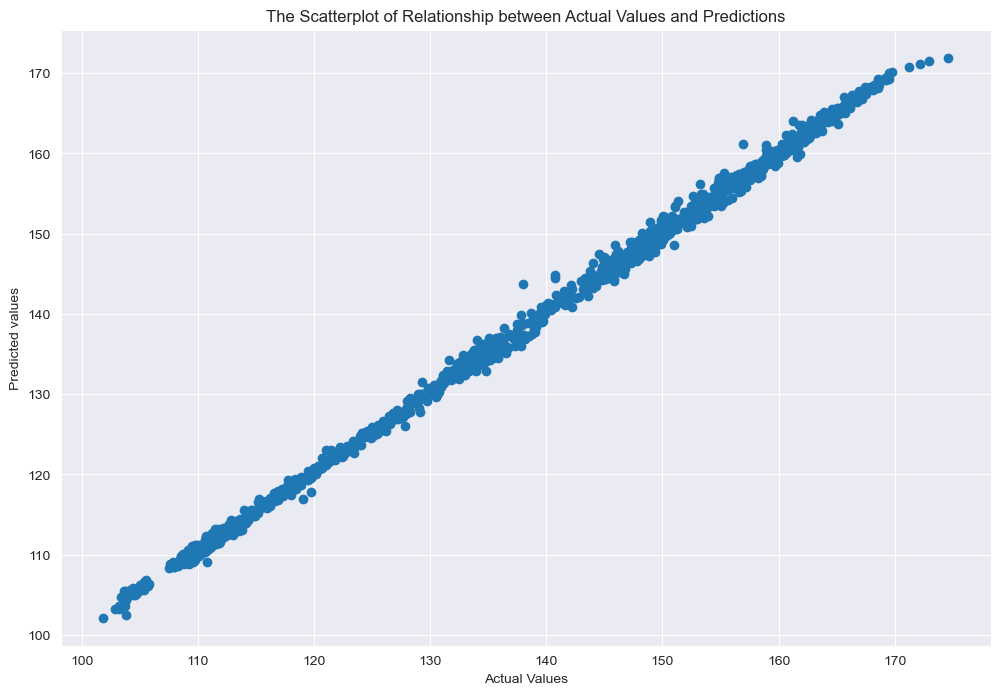

In [88]:
plt.figure(figsize=(12,8))
plt.xlabel("Actual Values")
plt.ylabel("Predicted values")
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.scatter(predictions_df['Actual'], predictions_df['Predicted'])

In [89]:
# We will evaluate our model performance by calculating the residual sum of squares and the explained variance score
from sklearn import metrics
print("MAE:",metrics.mean_absolute_error(y_test,y_predict_test))
print ("MSE:",metrics.mean_squared_error(y_test,y_predict_test))
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test,y_predict_test)))

MAE: 0.5248720880264934
MSE: 0.4585926805245507
RMSE: 0.6771947138929473


In [90]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_predict_test = model.predict(x_test_scaled)
y_predict_train = model.predict(x_train_scaled) 
print('R2_score (train): ',r2_score(y_train, y_predict_train))
print('R2_score (test): ',r2_score(y_test, y_predict_test))

376/376 [==============================] - 0s 235us/step
R2_score (train):  0.99859641104582
R2_score (test):  0.9981684836428245


# Residual Analysis

/var/folders/cm/j358s8y57ddbtd58gtsc0wwr0000gn/T/ipykernel_861/1828132719.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-y_predict_test,bins=50) #this figure also proves that our model fits very good


<Axes: ylabel='Density'>

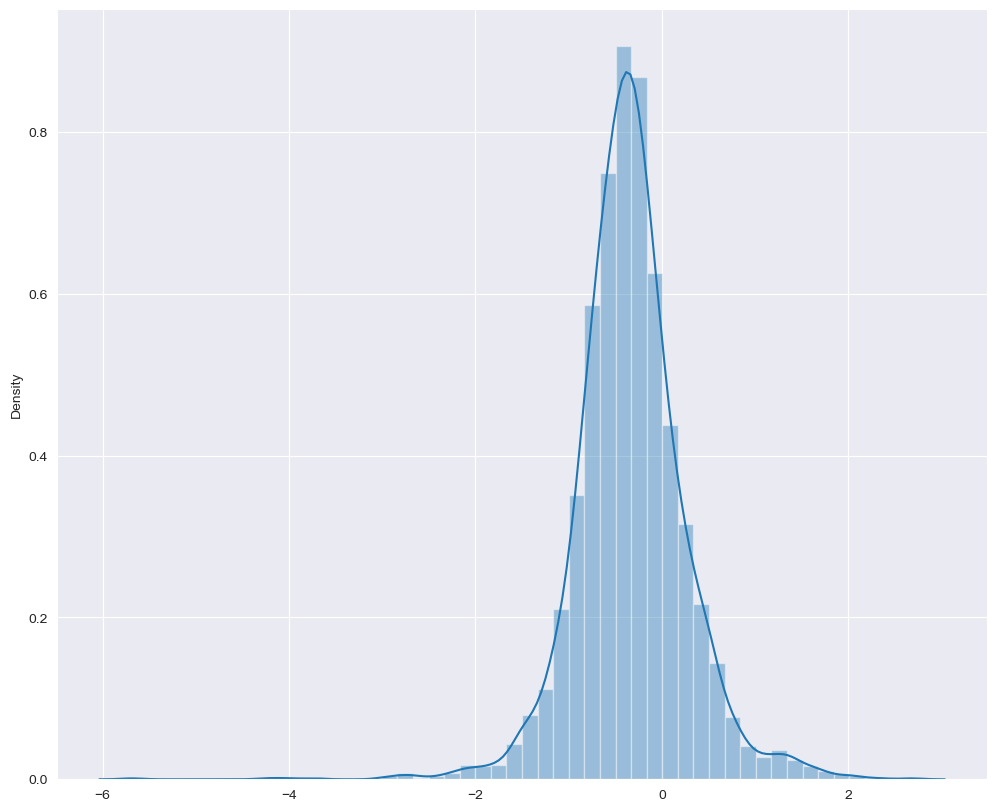

In [91]:
#Now we will visualize the differences between our predictions and actual y test data

plt.figure(figsize=(12,10))
sns.distplot(y_test-y_predict_test,bins=50) #this figure also proves that our model fits very good
#There is no huge differences between our predictions and actual y data

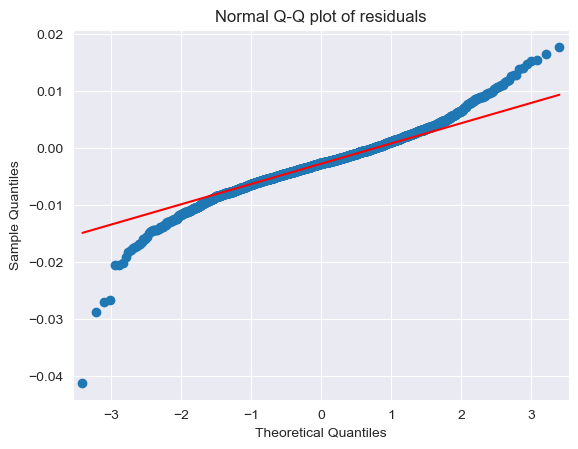

In [92]:
#Residuals values  = y - yhat
import statsmodels.api as smf
smf.qqplot(predictions_df['Error'], line = 'q')
plt.title('Normal Q-Q plot of residuals')
plt.show()

# Observation: Error should have Normal / Gaussian distribution~N(0,1) and independently and identically distributed.